In [152]:
# Bloque 1: Importar librerías
import yfinance as yf
import pandas as pd
import ta

In [153]:
def get_stock_data(ticker, period,interval):
    data = yf.download(ticker, period= period, interval=interval)
    data.columns = data.columns.droplevel(1)
    return data

ticker = "TSLA"
period = "730d"  # Últimos 60 días
interval = "1h"  # Datos por hora

data = get_stock_data(ticker,period,interval)

# Convertir el índice a columna
data.reset_index(inplace=True)

# Renombrar la columna si es necesario (por defecto se llamará "index")
data.rename(columns={'Datetime': 'Date'}, inplace=True)

# Convertir la columna 'Date' a formato datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Hour'] = data['Date'].dt.hour
# Crear columna de color del volumen como en TradingView
# Asignar 1 si el cierre es mayor que la apertura (verde), 0 si es menor o igual (rojo)
data["Volumen_Color_Num"] = (data["Close"] > data["Open"]).astype(int)

# Definir el tamaño de la ventana (aproximadamente 33 datos por semana)
ventana_semanal = 33

# Calcular el porcentaje de velas verdes en la última semana
data["Porcentaje_Velas_Verdes"] = data["Volumen_Color_Num"].rolling(window=ventana_semanal, min_periods=1).mean()

# Asignar categorías
data["Tendencia_Semanal"] = 1  # Neutral por defecto
data.loc[data["Porcentaje_Velas_Verdes"] > 0.7, "Tendencia_Semanal"] = 2  # Alcista
data.loc[data["Porcentaje_Velas_Verdes"] < 0.3, "Tendencia_Semanal"] = 0  # Bajista

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour,Volumen_Color_Num,Porcentaje_Velas_Verdes,Tendencia_Semanal
0,2022-04-20 13:30:00+00:00,331.940002,344.666656,330.456665,343.333344,6172282,20,4,13,0,0.00,0
1,2022-04-20 14:30:00+00:00,331.513336,335.666656,330.923340,331.943329,2927385,20,4,14,0,0.00,0
2,2022-04-20 15:30:00+00:00,326.666656,332.576660,326.000000,331.576660,2784664,20,4,15,0,0.00,0
3,2022-04-20 16:30:00+00:00,328.426666,330.100006,326.666656,326.666656,2131408,20,4,16,1,0.25,0
4,2022-04-20 17:30:00+00:00,328.346649,330.433319,328.019989,328.423340,1441106,20,4,17,0,0.20,0


In [154]:
def calculate_indicators(data):
    # ===================== 📌 MEDIAS MÓVILES =====================
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()

    # ===================== 🔥 BOLLINGER BANDS =====================
    data['BB_upper'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['BB_lower'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()
    data['BBW'] = (data['BB_upper'] - data['BB_lower']) / data['Close']  # Ancho de BB

    # ===================== 📊 VOLUMEN =====================
    data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
    data['Vol_Ratio_10h'] = data['Volume'] / data['Volume'].rolling(window=10).mean()

    # ===================== 🔄 CAMBIOS PORCENTUALES =====================
    data['Hourly_Return'] = data['Close'].pct_change() * 100
    data['Cumulative_Return'] = data['Close'].pct_change(periods=5) * 100  # Cambio acumulado en 5 horas

    # ===================== 📈 MACD =====================
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # ===================== 📊 RSI =====================
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)

    # ===================== 📉 ATR =====================
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=14)

    # ===================== 📊 ADX (Índice de Dirección Media) =====================
    data['ADX'] = ta.trend.adx(data['High'], data['Low'], data['Close'], window=14)

    # ===================== 🔄 ESTOCÁSTICO =====================
    data['Stoch_K'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)
    data['Stoch_D'] = ta.momentum.stoch_signal(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)

    # ===================== 🔥 MOMENTUM =====================
    data['MOM'] = ta.momentum.roc(data['Close'], window=10)

    # ===================== 🔎 OBV (On-Balance Volume) =====================
    data['OBV'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])

    # ===================== 💰 CMF (Chaikin Money Flow) =====================
    data['CMF'] = ta.volume.chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'], window=20)

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data

# Aplicar la función al dataframe
data = calculate_indicators(data)

# Mostrar primeras filas con indicadores
print(data.head())


Price                      Date       Close        High         Low  \
49    2022-04-29 13:30:00+00:00  305.736664  311.466644  296.696686   
50    2022-04-29 14:30:00+00:00  302.166656  307.959961  300.339996   
51    2022-04-29 15:30:00+00:00  301.900909  306.333344  300.500000   
52    2022-04-29 16:30:00+00:00  300.434998  301.888336  297.739990   
53    2022-04-29 17:30:00+00:00  294.829987  301.933319  294.000000   

Price        Open    Volume  Day  Month  Hour  Volumen_Color_Num  ...  \
49     300.750000  10949405   29      4    13                  1  ...   
50     305.666656   3851016   29      4    14                  0  ...   
51     301.916656   2767266   29      4    15                  0  ...   
52     301.888336   2303012   29      4    16                  0  ...   
53     300.353363   2287675   29      4    17                  0  ...   

Price      MACD  MACD_Signal        RSI       ATR        ADX    Stoch_K  \
49    -6.809555    -9.154967  53.228241  8.421516  32.03492

In [155]:
import numpy as np

# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================
data['Past_Change_1w'] = (data['Close'] - data['Close'].shift(35)) / data['Close'].shift(35) * 100
data['Past_Change_2w'] = (data['Close'] - data['Close'].shift(70)) / data['Close'].shift(70) * 100
data['Past_Change_1m'] = (data['Close'] - data['Close'].shift(140)) / data['Close'].shift(140) * 100

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data['Future_Change_2w'] = (data['Close'].shift(-70) - data['Close']) / data['Close'] * 100

# ===================== 📌 FUNCIÓN PARA CLASIFICAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerte
    elif percentage <= percentiles[1]:
        return 1  # Venta
    elif percentage <= percentiles[2]:
        return 2  # Neutral
    elif percentage <= percentiles[3]:
        return 3  # Compra
    else: 
        return 4

# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data['Past_Change_1w'].dropna(), [15, 40,58 ,80])
percentiles_2w = np.percentile(data['Past_Change_2w'].dropna(), [15, 40,58 ,80])
percentiles_1m = np.percentile(data['Past_Change_1m'].dropna(), [15, 40,58 ,80])
percentiles_future_2w = np.percentile(data['Future_Change_2w'].dropna(), [15, 40,58 ,80])

# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data['Past_Class_1w'] = data['Past_Change_1w'].apply(lambda x: classify_change(x, percentiles_1w))
data['Past_Class_2w'] = data['Past_Change_2w'].apply(lambda x: classify_change(x, percentiles_2w))
data['Past_Class_1m'] = data['Past_Change_1m'].apply(lambda x: classify_change(x, percentiles_1m))
data['Future_Class_2w'] = data['Future_Change_2w'].apply(lambda x: classify_change(x, percentiles_future_2w))

# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)

Percentiles de cambios pasados (2 semanas): [-12.99896989  -3.22337506   2.68390383  10.34984913]


In [156]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Day', 'Month',
       'Hour', 'Volumen_Color_Num', 'Porcentaje_Velas_Verdes',
       'Tendencia_Semanal', 'EMA12', 'EMA26', 'EMA50', 'SMA50', 'BB_upper',
       'BB_lower', 'BBW', 'Volume_MA', 'Vol_Ratio_10h', 'Hourly_Return',
       'Cumulative_Return', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'ADX',
       'Stoch_K', 'Stoch_D', 'MOM', 'OBV', 'CMF', 'Past_Change_1w',
       'Past_Change_2w', 'Past_Change_1m', 'Future_Change_2w', 'Past_Class_1w',
       'Past_Class_2w', 'Past_Class_1m', 'Future_Class_2w'],
      dtype='object', name='Price')

In [157]:
data = data.drop(columns=['Cumulative_Return','Stoch_K','Stoch_D',
                          'Vol_Ratio_10h', 'Hourly_Return','Hour',]) ## Aquí se hacen las pruebas 

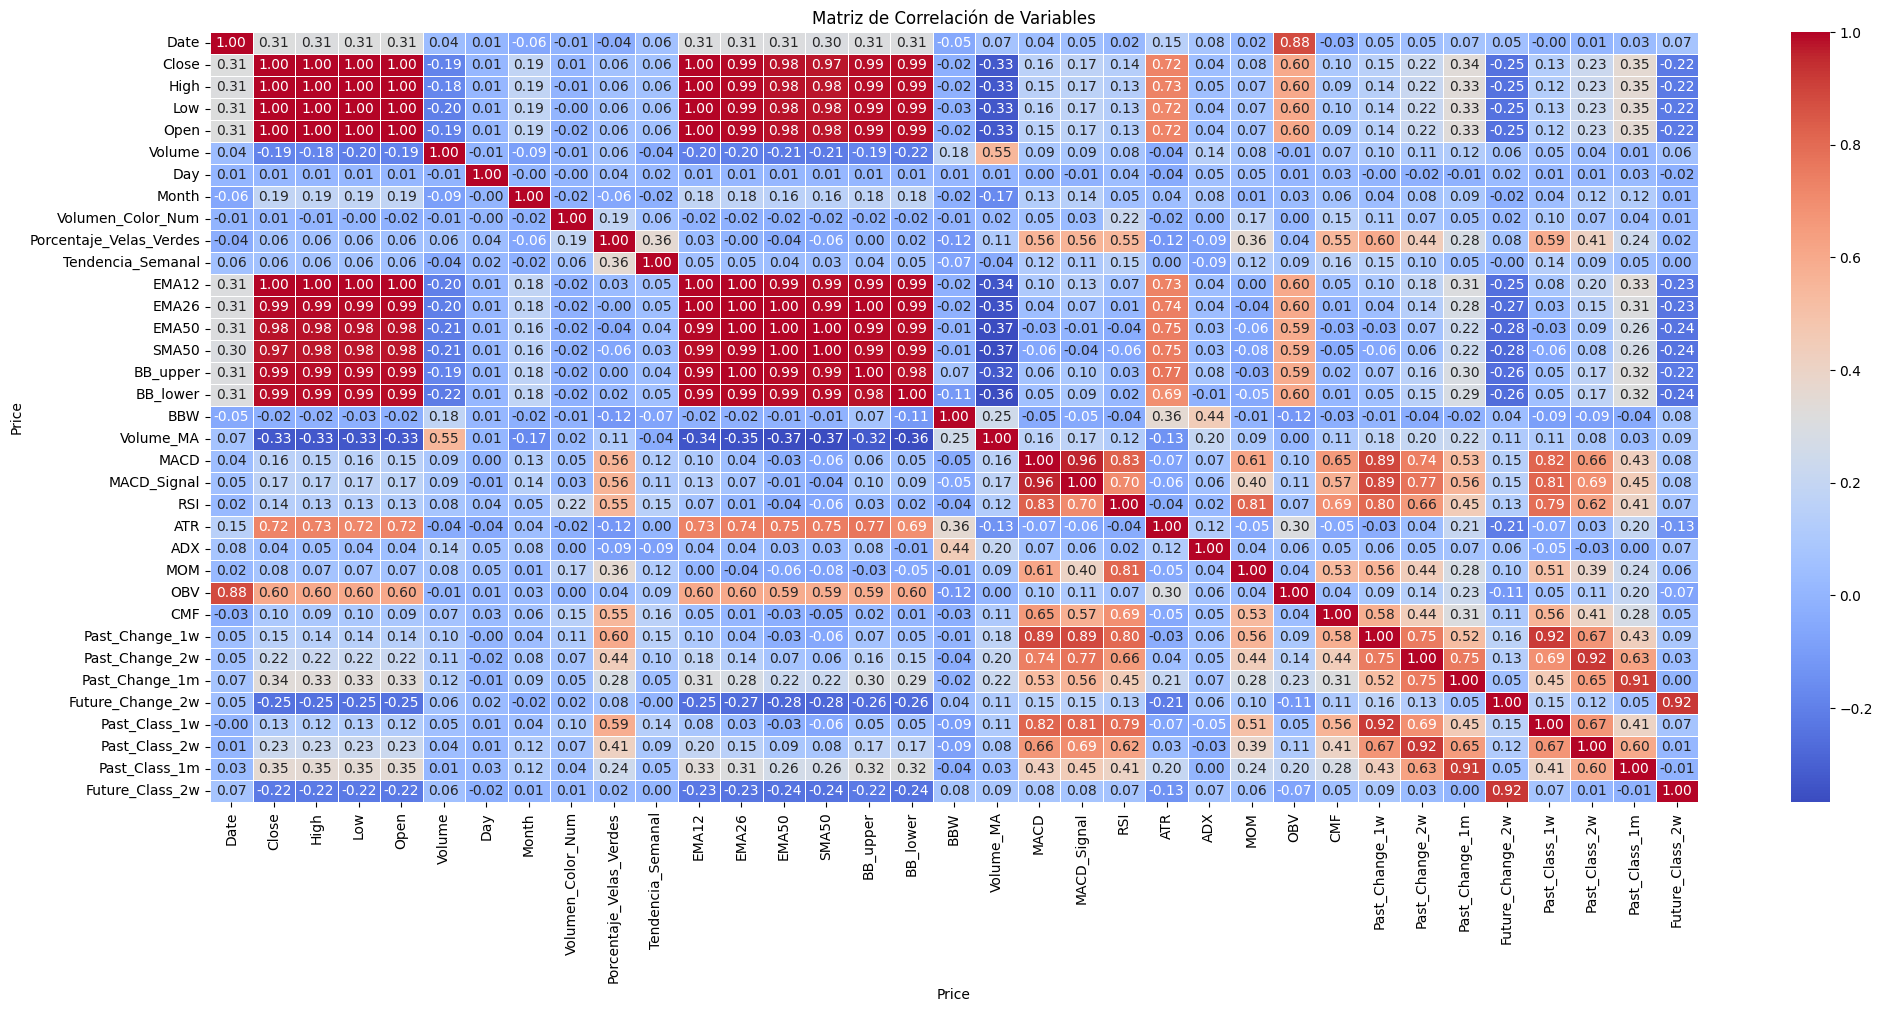

Price
Future_Class_2w            1.000000
Future_Change_2w           0.923742
Past_Change_1w             0.090005
Volume_MA                  0.089156
MACD                       0.082417
BBW                        0.080431
MACD_Signal                0.079287
Past_Class_1w              0.073246
Date                       0.072372
ADX                        0.070406
RSI                        0.067435
MOM                        0.058824
Volume                     0.057005
CMF                        0.051147
Past_Change_2w             0.031086
Porcentaje_Velas_Verdes    0.020339
Volumen_Color_Num          0.012152
Past_Class_2w              0.008162
Month                      0.006040
Tendencia_Semanal          0.001844
Past_Change_1m             0.000576
Past_Class_1m             -0.011307
Day                       -0.022821
OBV                       -0.070040
ATR                       -0.133255
Close                     -0.221901
High                      -0.222025
BB_upper              

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()
print(correlation_matrix['Future_Class_2w'].sort_values(ascending=False)) 

In [159]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report

# Eliminar valores nulos
data_train = data.dropna()

print(data_train["Future_Class_2w"].value_counts())

# Preparar los datos
X = data_train.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)  # Características (todas las columnas menos la columna objetivo)
y = data_train["Future_Class_2w"]  # Columna objetivo

# Normalización de las características usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)  # Aplicamos el escalado a las características

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Inicializar los modelos
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500,  # Más árboles para estabilidad
        max_depth=10,  # Evitar sobreajuste
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,  # Paralelización
    ),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_estimators=500,  # Más iteraciones
        learning_rate=0.01,  # Más bajo para estabilidad
        max_depth=6,  # Controla sobreajuste
        subsample=0.8,  # Evita overfitting
        colsample_bytree=0.8,
        gamma=0.1,  # Reduce falsos positivos
        min_child_weight=5,  # Evita divisiones poco útiles
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,  # Baja tasa para estabilidad
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,  # Evitar overfitting
        random_state=42,
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",  # Indicar que es clasificación multiclase
        num_class=5,  # Número total de clases
        n_estimators=500,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}

Future_Class_2w
1    1232
3    1069
4     977
2     861
0     688
Name: count, dtype: int64


In [160]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [161]:
print(X_train.shape)
print(X_test.shape)

(3378, 32)
(1449, 32)


In [162]:
# Entrenar y evaluar cada modelo
predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir sobre el conjunto de prueba
    predictions[model_name] = y_pred

# Mostrar las métricas para cada modelo
model_metrics = {}
for model_name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    model_metrics[model_name] = report

# model_metrics

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [163]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores = {}

for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 ponderado
    kappa = cohen_kappa_score(y_test, y_pred)  # Cohen's Kappa

    model_scores[model_name] = {'accuracy': accuracy, 'f1_score': f1, 'kappa': kappa}

# Ordenar modelos por precisión (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models = sorted(model_scores.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Imprimir los 3 mejores modelos
print("🔹 Top 3 Modelos Basados en Precisión:")
for i, (model_name, scores) in enumerate(sorted_models[:3]):
    print(f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}")
    

🔹 Top 3 Modelos Basados en Precisión:
1. LightGBM - Precisión: 0.8834 | F1-Score: 0.8835 | Kappa: 0.8526
2. Gradient Boosting - Precisión: 0.8772 | F1-Score: 0.8774 | Kappa: 0.8446
3. XGBoost - Precisión: 0.8337 | F1-Score: 0.8334 | Kappa: 0.7892


In [164]:
# Mostrar la cantidad de cada predicción por modelo
prediction_counts = {}

for model_name, y_pred in predictions.items():
    unique, counts = np.unique(y_pred, return_counts=True)  # Contar la frecuencia de cada predicción
    prediction_counts[model_name] = dict(zip(unique, counts))
    

In [165]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df = {}

for model_name, y_pred in predictions.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df[model_name] = pd.DataFrame({
        'Real': y_test,  # Valores reales
        'Predicción': y_pred  # Predicciones del modelo
    })

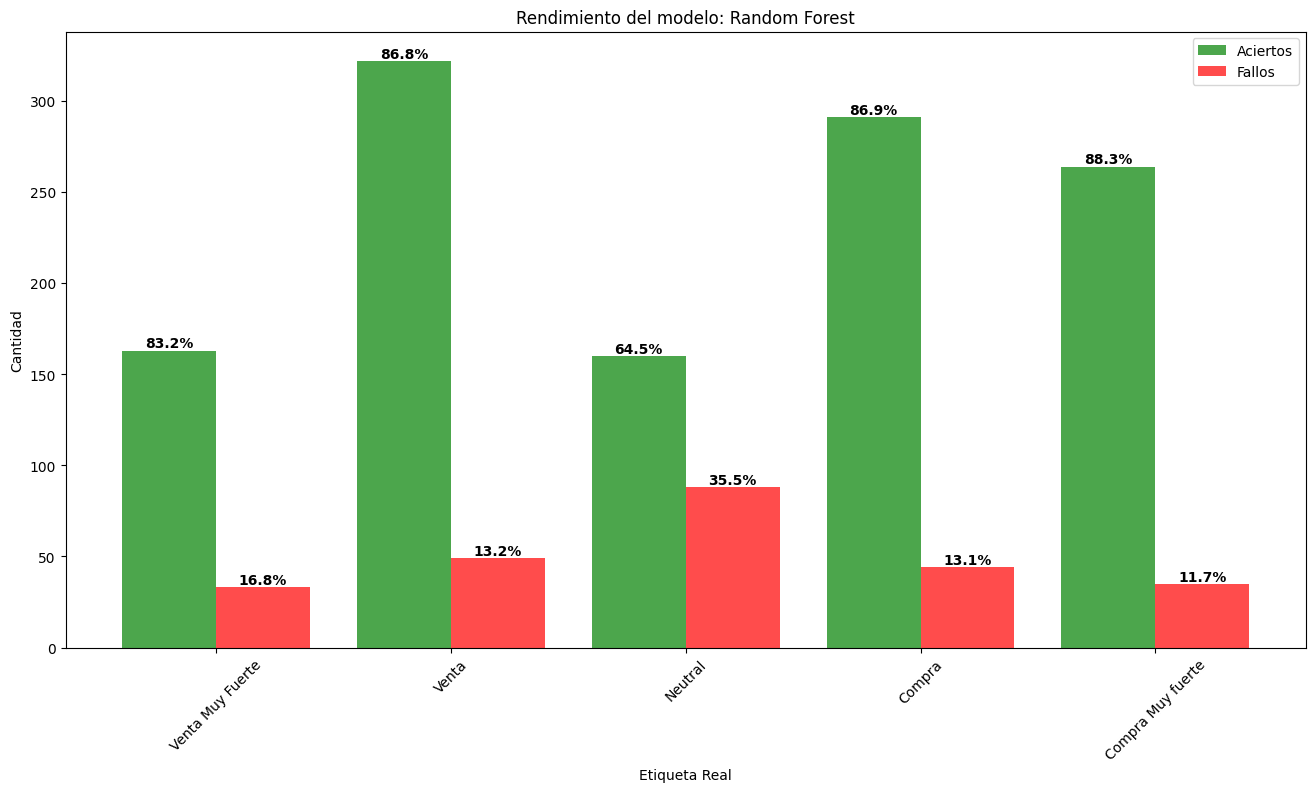

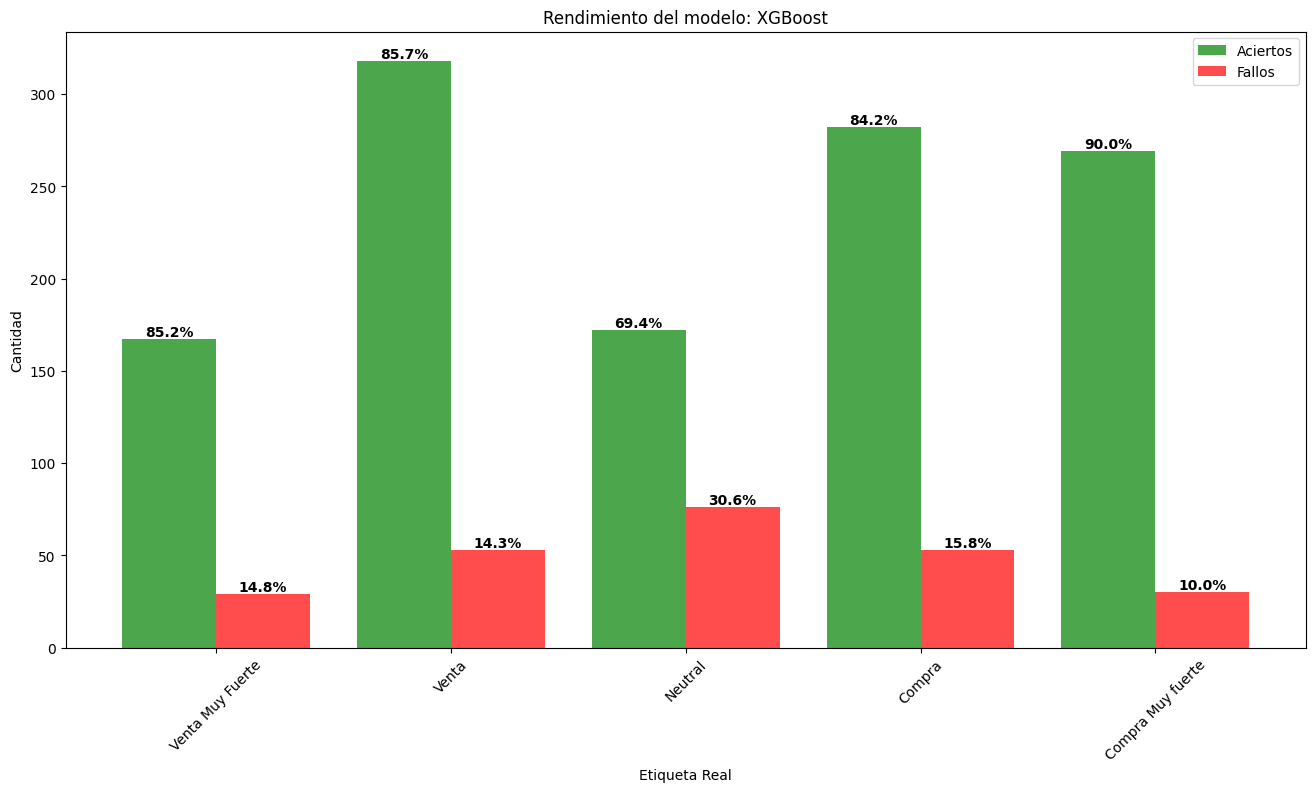

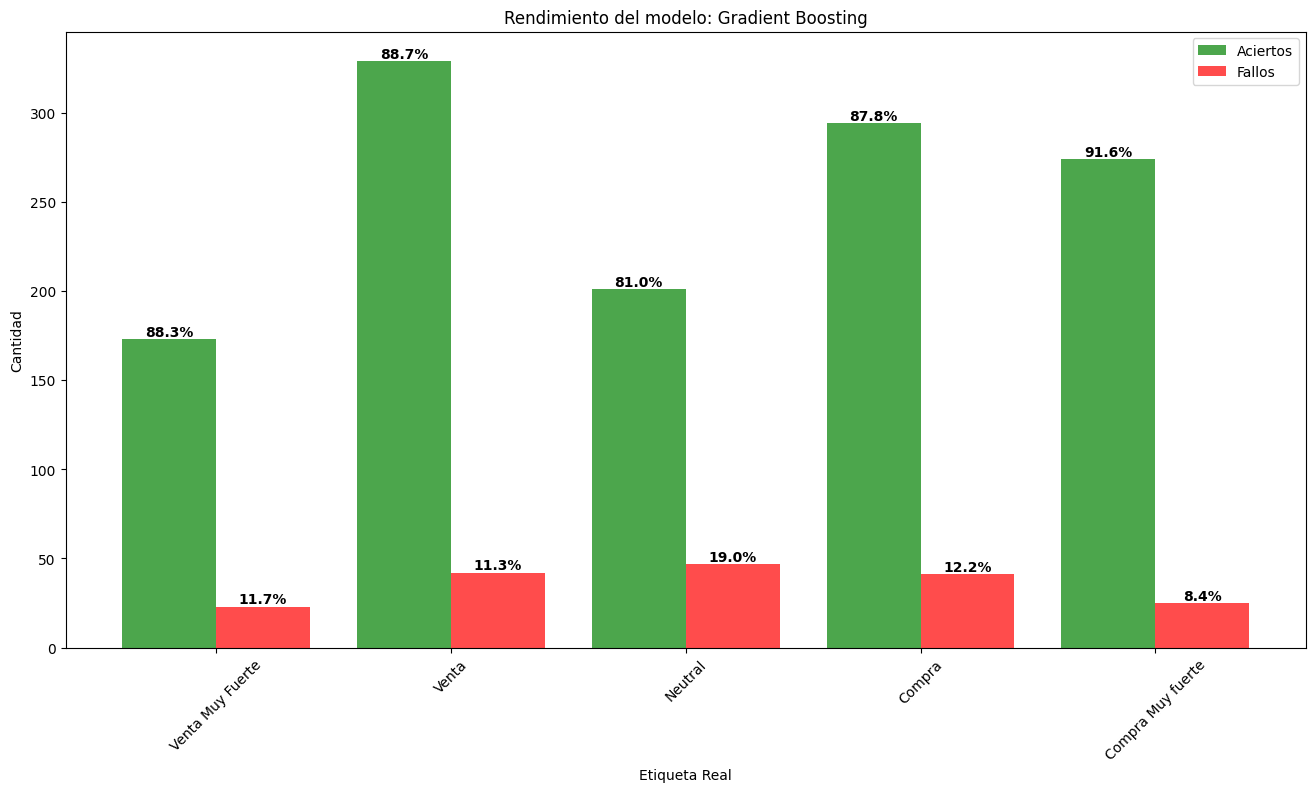

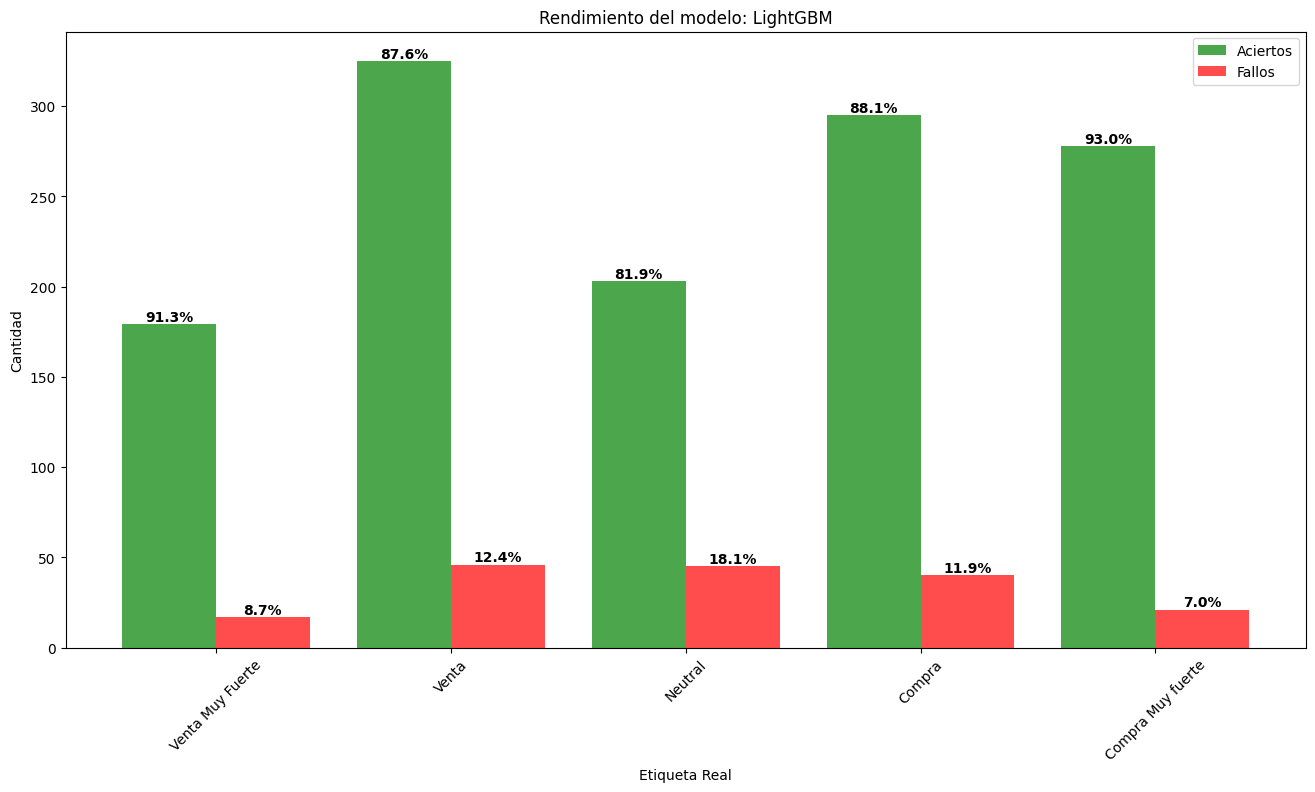

In [166]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: 'Venta Muy Fuerte',
    1: 'Venta',
    2: 'Neutral',
    3: 'Compra',
    4: 'Compra Muy fuerte',
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones
comparison_df = {}

for model_name, y_pred in predictions.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({
        'Real': y_test, 
        'Predicción': y_pred
    })
    
    # Convertir los valores numéricos a etiquetas de texto
    df['Real'] = df['Real'].map(label_mapping)
    df['Predicción'] = df['Predicción'].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df['Real'] = pd.Categorical(df['Real'], categories=ordered_labels, ordered=True)
    df['Predicción'] = pd.Categorical(df['Predicción'], categories=ordered_labels, ordered=True)

    # Guardar en el diccionario
    comparison_df[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df.items():
    df['Correcto'] = df['Real'] == df['Predicción']  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = df.groupby(['Real', 'Correcto'], observed=False).size().unstack(fill_value=0)

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: 'Aciertos', False: 'Fallos'})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=['Aciertos', 'Fallos'], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))
    
    # Barras de aciertos (izquierda)
    bars1 = plt.bar(x - width/2, results['Aciertos'], width=width, color='green', alpha=0.7, label='Aciertos')

    # Barras de fallos (derecha)
    bars2 = plt.bar(x + width/2, results['Fallos'], width=width, color='red', alpha=0.7, label='Fallos')

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages['Aciertos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct1:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    for bar, pct2 in zip(bars2, percentages['Fallos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct2:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 🔹 Formato final de la gráfica
    plt.title(f'Rendimiento del modelo: {model_name}')
    plt.xlabel('Etiqueta Real')
    plt.ylabel('Cantidad')
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()

In [167]:
# Obtener los datos de ayer (última fila)
yesterday_data = data.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_np = (
    X_yesterday.to_numpy()
)  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[
        0
    ]  # Obtener la predicción numérica

    future_predictions[model_name] = (
        f"📉 Caída muy fuerte (< {percentiles_future_2w[0]:.2f}%)"
        if future_prediction == 0
        else (
            f"🔻 Caída ({percentiles_future_2w[0]:.2f}% a {percentiles_future_2w[1]:.2f}%)"
            if future_prediction == 1
            else (
                f"🔻 Sin cambios significativos ({percentiles_future_2w[1]:.2f}% a {percentiles_future_2w[2]:.2f}%)"
                if future_prediction == 2
                else (
                    f"➖ Subida ({percentiles_future_2w[2]:.2f}% a {percentiles_future_2w[3]:.2f}%)"
                    if future_prediction == 3
                    else (
                        f"🔼 Subida muy fuerte (> {percentiles_future_2w[3]:.2f}%)"
                    )
                )
            )
        )
    )

# Mostrar los resultados con fecha formateada correctamente
print(
    f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}"
)
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


📅 Fecha de la última observación: 2025-03-18 19:30
💰 Precio de cierre: 225.48 USD

🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:
⚡ Random Forest: 📉 Caída muy fuerte (< -13.00%)
⚡ XGBoost: 🔻 Caída (-13.00% a -3.22%)
⚡ Gradient Boosting: 📉 Caída muy fuerte (< -13.00%)
⚡ LightGBM: 🔻 Caída (-13.00% a -3.22%)


In [168]:
import matplotlib.pyplot as plt

# Últimos 350 registros para graficar historial
data_last_350 = data.tail(500)

# Obtener datos de ayer (última fila)
yesterday_data = data.iloc[-1:]
yesterday_date = yesterday_data['Date'].values[0]
yesterday_close = yesterday_data['Close'].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday_2w = yesterday_data.drop(columns=['Future_Change_2w', 'Future_Class_2w', 'Date'])
X_yesterday_2w_np = X_yesterday.to_numpy()

# Definir cuántos pasos futuros extenderemos la banda
future_steps_2w = 50  
last_date = data_last_350['Date'].max()  # Última fecha en la data histórica
future_dates_2w = pd.date_range(start=last_date, periods=future_steps_2w + 1, freq='h')[1:]

In [169]:
def check_prediction_for_specific_day(data, x, periods_ahead=70):
    """
    Verifica la predicción de los modelos para una fecha específica `x` períodos atrás 
    y su resultado futuro en 'Future_Class_2w', mostrando ambos cierres.
    """
    # Verificar si hay suficientes datos hacia atrás
    if x >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return
    
    # Obtener los datos de hace `x` períodos
    specific_day_data = data.iloc[-x]  # Últimos `x` períodos hacia atrás
    specific_date = specific_day_data['Date']

    # Calcular la fecha futura correctamente
    future_index = -x + periods_ahead  # 70 períodos adelante (~2 semanas en 1h)
    
    if future_index < len(data):  
        future_day_data = data.iloc[future_index]
        future_date = future_day_data['Date']
        close_future = future_day_data['Close']
    else:
        future_date = "N/A"
        close_future = None  # No hay suficiente data para ver el cierre futuro
    
    # Seleccionar características para el modelo (excluyendo la columna objetivo y la fecha)
    features = [col for col in data.columns if col not in ['Future_Change_2w', 'Future_Class_2w', 'Date']]
    X_specific_day = specific_day_data[features]

    # Realizar predicciones con cada modelo
    specific_day_predictions = {}
    for model_name, model in models.items():
        future_prediction = model.predict([X_specific_day])
        specific_day_predictions[model_name] = future_prediction[0]  # Guardar la predicción

    # Obtener la clase real y el cambio futuro
    real_class_future = specific_day_data['Future_Class_2w']
    real_change_future = specific_day_data['Future_Change_2w']

    # Determinar en qué rango cae el cambio real según los percentiles
    real_class_from_change = (
        0 if real_change_future <= percentiles_future_2w[0] else
        1 if real_change_future <= percentiles_future_2w[1] else
        2 if real_change_future <= percentiles_future_2w[2] else
        3 if real_change_future <= percentiles_future_2w[3] else
        4 
    )

    # 📌 Mostrar resultados con fecha real y cierres
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {specific_day_data['Close']:.2f} USD")
    print(f"📅 Fecha futura (2 semanas después): {future_date if future_date != 'N/A' else 'No disponible'}")
    
    if close_future is not None:
        print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    
    print(f"🔹 Clase real 'Future_Class_2w': {real_class_future}")
    print(f"🔹 Cambio real: {real_change_future:.2f}% -> Clasificado como {real_class_from_change}")

    print(f"\n📊 Percentiles para clasificación:")
    for i, perc in enumerate(percentiles_future_2w):
        print(f"   🔹 Percentil {i}: {perc:.2f}%")

    print("\n🔍 Predicciones de los modelos:")
    for model_name, prediction in specific_day_predictions.items():
        resultado = "✅ Acertó!" if prediction == real_class_future else "❌ No acertó."
        print(f"   {model_name}: Predicción = {prediction} | Real = {real_class_future} -> {resultado}")

    # 🚀 Depuración si hay errores en la fecha futura
    if isinstance(future_date, str) or future_date.year < 2025:
        print("\n⚠️ Posible error en el cálculo de la fecha futura.")
        print(f"   Índice futuro esperado: {future_index}")
        print(f"   Fecha estimada en DataFrame: {future_date}")

# 🔹 **Ejemplo de uso:**
print(data.shape)       

check_prediction_for_specific_day(data, x=71)  # Verifica hace 100 períodos (~4-5 días hábiles en 1h)

(5037, 35)

📅 Fecha evaluada: 2025-03-04 20:30:00
💰 Cierre en la fecha evaluada: 272.00 USD
📅 Fecha futura (2 semanas después): 2025-03-18 19:30:00+00:00
💰 Cierre en la fecha futura: 225.48 USD
🔹 Clase real 'Future_Class_2w': 0
🔹 Cambio real: -17.10% -> Clasificado como 0

📊 Percentiles para clasificación:
   🔹 Percentil 0: -13.00%
   🔹 Percentil 1: -3.22%
   🔹 Percentil 2: 2.68%
   🔹 Percentil 3: 10.35%

🔍 Predicciones de los modelos:
   Random Forest: Predicción = 0 | Real = 0 -> ✅ Acertó!
   XGBoost: Predicción = 1 | Real = 0 -> ❌ No acertó.
   Gradient Boosting: Predicción = 0 | Real = 0 -> ✅ Acertó!
   LightGBM: Predicción = 1 | Real = 0 -> ❌ No acertó.



📅 Fecha evaluada: 2025-01-30 15:30:00
💰 Cierre en la fecha evaluada: 397.11 USD
📅 Fecha futura (2 semanas después): 2025-02-13 15:30:00
💰 Cierre en la fecha futura: 352.76 USD
📈 Cambio real en porcentaje: -11.17%

🔍 Predicciones de los modelos y precios proyectados:
   Random Forest: Predicción = 0 | Rango esperado = 305.78 - 345.49 USD
   🎯 Rango de percentiles: -23.00% - -13.00% -> ❌ No acertó.
   XGBoost: Predicción = 1 | Rango esperado = 345.49 - 384.31 USD
   🎯 Rango de percentiles: -13.00% - -3.22% -> ✅ Acertó!
   Gradient Boosting: Predicción = 0 | Rango esperado = 305.78 - 345.49 USD
   🎯 Rango de percentiles: -23.00% - -13.00% -> ❌ No acertó.
   LightGBM: Predicción = 1 | Rango esperado = 345.49 - 384.31 USD
   🎯 Rango de percentiles: -13.00% - -3.22% -> ✅ Acertó!


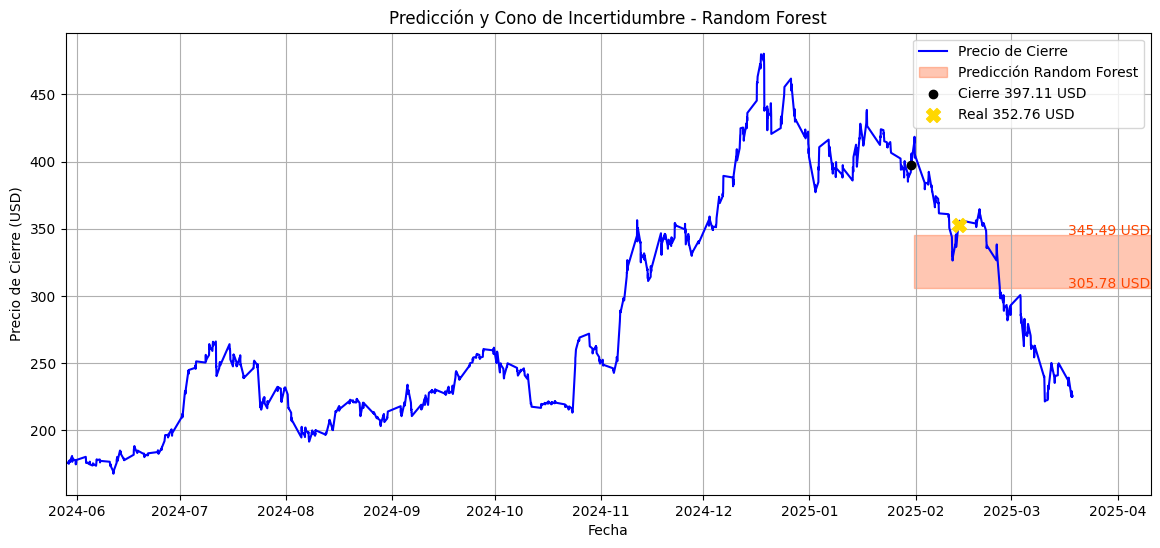

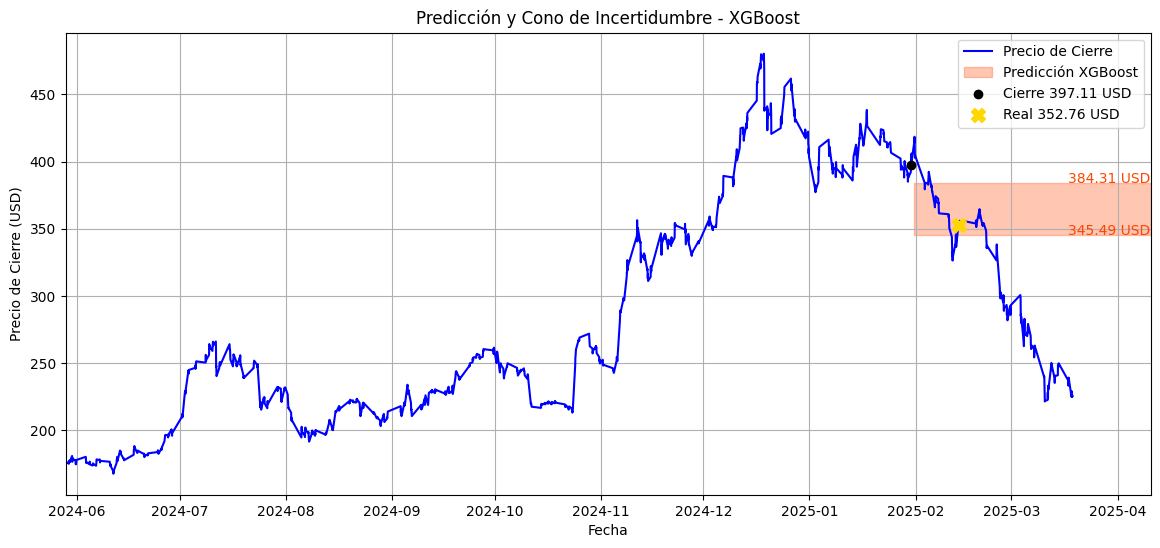

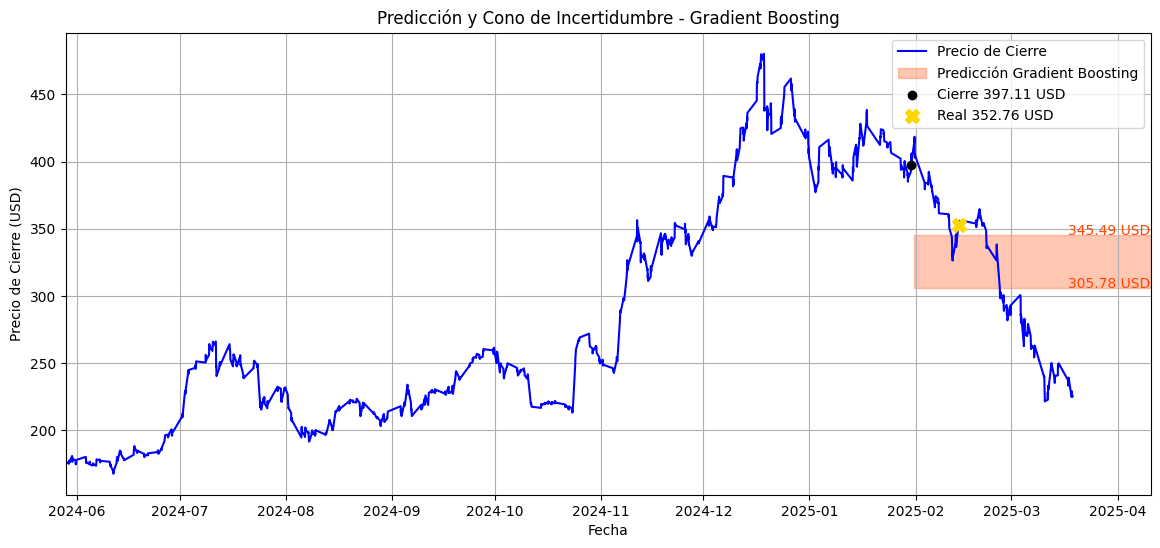

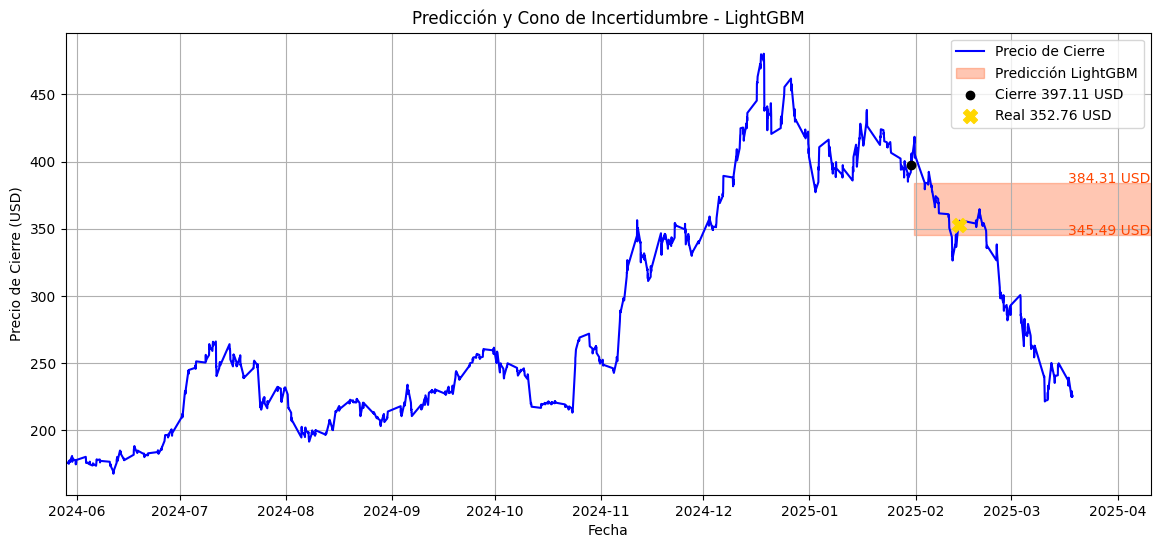

In [170]:
def check_prediction_with_cone(data, x, periods_ahead=70, num_days_to_plot=200):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return
    
    # 🔹 Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]  
    specific_date = specific_day_data['Date']
    close_actual = specific_day_data['Close']
    
    # 🔹 Obtener datos del punto futuro donde se verificará la predicción
    future_day_data = data.iloc[-x + periods_ahead]  
    future_date = future_day_data['Date']
    close_future = future_day_data['Close']

    # 🔹 Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características para la predicción
    features = [col for col in data.columns if col not in ['Future_Change_2w', 'Future_Class_2w', 'Date']]
    X_specific_day = specific_day_data[features]

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models.items():
        future_prediction = int(model.predict([X_specific_day])[0])
        specific_day_predictions[model_name] = future_prediction
        
        # 🔹 Determinar el rango según la predicción
        if future_prediction == 0:  # Caída muy fuerte
            color = 'red'
            pred_range = (percentiles_future_2w[0] - 10, percentiles_future_2w[0])
        elif future_prediction == 1:  # Caída moderada
            color = 'orangered'
            pred_range = (percentiles_future_2w[0], percentiles_future_2w[1])
        elif future_prediction == 2:  # Sin cambios significativos
            color = 'gray'
            pred_range = (percentiles_future_2w[1], percentiles_future_2w[2])
        elif future_prediction == 3:  # Subida moderada
            color = 'limegreen'
            pred_range = (percentiles_future_2w[2], percentiles_future_2w[3])
        else:  # Subida muy fuerte
            color = 'green'
            pred_range = (percentiles_future_2w[3], percentiles_future_2w[3] + 10)

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (projected_price_min, projected_price_max, pred_range[0], pred_range[1])

    # 📌 Mostrar resultados
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(f"📅 Fecha futura (2 semanas después): {future_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"📈 Cambio real en porcentaje: {real_change_percent:.2f}%")

    print("\n🔍 Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[model_name]
        
        if percentile_min <= real_change_percent <= percentile_max:
            resultado = "✅ Acertó!"
        else:
            resultado = "❌ No acertó."

        print(f"   {model_name}: Predicción = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD")
        print(f"   🎯 Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}")

    # 🚀 Graficar con el cono de predicción (una gráfica por modelo)
    future_steps = periods_ahead
    future_dates = pd.date_range(start=specific_date, periods=future_steps + 1, freq='D')[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        # 🔹 Graficar el historial del precio de cierre
        plt.figure(figsize=(14, 6))
        plt.plot(data.iloc[-num_days_to_plot:]['Date'], 
                 data.iloc[-num_days_to_plot:]['Close'], 
                 label='Precio de Cierre', color='blue')

        # 🔹 Graficar el cono de predicción
        lower_bound = [close_actual * (1 + (projected_prices[model_name][2] / 100))] * len(future_dates)
        upper_bound = [close_actual * (1 + (projected_prices[model_name][3] / 100))] * len(future_dates)

        plt.fill_between(future_dates, lower_bound, upper_bound, color=color, alpha=0.3, label=f'Predicción {model_name}')
        
        # 🔹 Etiquetas de los valores proyectados en el extremo derecho
        plt.text(future_dates[-1], lower_bound[-1], f"{lower_bound[-1]:.2f} USD", color=color, fontsize=10, ha='right')
        plt.text(future_dates[-1], upper_bound[-1], f"{upper_bound[-1]:.2f} USD", color=color, fontsize=10, ha='right')

        # 🔹 Marcar el punto de inicio de la predicción y el cierre real futuro
        plt.scatter(specific_date, close_actual, color='black', zorder=3, label=f'Cierre {close_actual:.2f} USD')
        plt.scatter(future_date, close_future, color='gold', marker='X', s=100, zorder=4, label=f'Real {close_future:.2f} USD')

        # Configuración del gráfico
        plt.xlabel('Fecha')
        plt.ylabel('Precio de Cierre (USD)')
        plt.title(f'Predicción y Cono de Incertidumbre - {model_name}')
        plt.legend()
        plt.grid(True)

        plt.xlim(data.iloc[-num_days_to_plot]['Date'], future_dates[-1])
        plt.show()

# Llamada a la función con los parámetros deseados
check_prediction_with_cone(data, x=230, periods_ahead=70, num_days_to_plot=1400)

# Parte 2 meses

In [195]:
data = get_stock_data(ticker,period,interval)

# Convertir el índice a columna
data.reset_index(inplace=True)

# Renombrar la columna si es necesario (por defecto se llamará "index")
data.rename(columns={'Datetime': 'Date'}, inplace=True)

# Convertir la columna 'Date' a formato datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Hour'] = data['Date'].dt.hour
# Crear columna de color del volumen como en TradingView
# Asignar 1 si el cierre es mayor que la apertura (verde), 0 si es menor o igual (rojo)
data["Volumen_Color_Num"] = (data["Close"] > data["Open"]).astype(int)

# Definir el tamaño de la ventana (aproximadamente 33 datos por semana)
ventana_semanal = 33

# Calcular el porcentaje de velas verdes en la última semana
data["Porcentaje_Velas_Verdes"] = data["Volumen_Color_Num"].rolling(window=ventana_semanal, min_periods=1).mean()

# Asignar categorías
data["Tendencia_Semanal"] = 1  # Neutral por defecto
data.loc[data["Porcentaje_Velas_Verdes"] > 0.7, "Tendencia_Semanal"] = 2  # Alcista
data.loc[data["Porcentaje_Velas_Verdes"] < 0.3, "Tendencia_Semanal"] = 0  # Bajista
data = calculate_indicators(data)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour,Volumen_Color_Num,...,MACD,MACD_Signal,RSI,ATR,ADX,Stoch_K,Stoch_D,MOM,OBV,CMF
49,2022-04-29 13:30:00+00:00,305.736664,311.466644,296.696686,300.750000,10949405,29,4,13,1,...,-6.809555,-9.154967,53.228241,8.421516,32.034922,84.747162,68.349429,2.792816,-20303881,-0.119042
50,2022-04-29 14:30:00+00:00,302.166656,307.959961,300.339996,305.666656,3851016,29,4,14,0,...,-5.700336,-8.464040,50.206522,8.364262,30.379556,75.244032,72.645042,2.746323,-24154897,-0.163258
51,2022-04-29 15:30:00+00:00,301.900909,306.333344,300.500000,301.916656,2767266,29,4,15,0,...,-4.787528,-7.728738,49.979073,8.183482,28.842431,74.536631,78.175942,2.702522,-26922163,-0.155122
52,2022-04-29 16:30:00+00:00,300.434998,301.888336,297.739990,301.888336,2303012,29,4,16,0,...,-4.134744,-7.009939,48.669279,7.896156,27.022392,70.634468,73.471710,8.988846,-29225175,-0.179615
53,2022-04-29 17:30:00+00:00,294.829987,301.933319,294.000000,300.353363,2287675,29,4,17,0,...,-4.023309,-6.412613,43.928848,7.898811,25.358872,55.714290,66.961796,5.329027,-31512850,-0.193478


In [196]:
import numpy as np

# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================
data['Past_Change_1w'] = (data['Close'] - data['Close'].shift(35)) / data['Close'].shift(35) * 100
data['Past_Change_1m'] = (data['Close'] - data['Close'].shift(140)) / data['Close'].shift(140) * 100
data['Past_Change_2m'] = (data['Close'] - data['Close'].shift(280)) / data['Close'].shift(280) * 100

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 MESES) =====================
data['Future_Change_2m'] = (data['Close'].shift(-280) - data['Close']) / data['Close'] * 100

# ===================== 📌 FUNCIÓN PARA CLASIFICAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerte
    elif percentage <= percentiles[1]:
        return 1  # Venta
    elif percentage <= percentiles[2]:
        return 2  # Neutral
    elif percentage <= percentiles[3]:
        return 3  # Compra
    else:
        return 4  # Compra Muy Fuerte

# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data['Past_Change_1w'].dropna(), [15, 40,58 ,80])
percentiles_1m = np.percentile(data['Past_Change_1m'].dropna(), [15, 40,58 ,80])
percentiles_2m = np.percentile(data['Past_Change_2m'].dropna(), [15, 40,58 ,80])
percentiles_future_2m = np.percentile(data['Future_Change_2m'].dropna(), [15, 40,58 ,80])

# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data['Past_Class_1w'] = data['Past_Change_1w'].apply(lambda x: classify_change(x, percentiles_1w))
data['Past_Class_1m'] = data['Past_Change_1m'].apply(lambda x: classify_change(x, percentiles_1m))
data['Past_Class_2m'] = data['Past_Change_2m'].apply(lambda x: classify_change(x, percentiles_2m))
data['Future_Class_2m'] = data['Future_Change_2m'].apply(lambda x: classify_change(x, percentiles_future_2m))

# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 meses):", percentiles_2m)
print("Percentiles de cambios pasados (1 mes):", percentiles_1m)
print("Percentiles de cambios pasados (1 semana):", percentiles_1w)
print("Percentiles de cambios futuros (2 meses):", percentiles_future_2m)


Percentiles de cambios pasados (2 meses): [-22.66711767  -6.54440062   7.07626016  27.97547364]
Percentiles de cambios pasados (1 mes): [-16.86993277  -5.5297247    2.79787421  16.50106838]
Percentiles de cambios pasados (1 semana): [-8.51167506 -2.35717139  1.25091721  6.94993543]
Percentiles de cambios futuros (2 meses): [-22.66711767  -6.54440062   7.07626016  27.97547364]


In [173]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Day', 'Month',
       'Hour', 'Volumen_Color_Num', 'Porcentaje_Velas_Verdes',
       'Tendencia_Semanal', 'EMA12', 'EMA26', 'EMA50', 'SMA50', 'BB_upper',
       'BB_lower', 'BBW', 'Volume_MA', 'Vol_Ratio_10h', 'Hourly_Return',
       'Cumulative_Return', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'ADX',
       'Stoch_K', 'Stoch_D', 'MOM', 'OBV', 'CMF', 'Past_Change_1w',
       'Past_Change_1m', 'Past_Change_2m', 'Future_Change_2m', 'Past_Class_1w',
       'Past_Class_1m', 'Past_Class_2m', 'Future_Class_2m'],
      dtype='object', name='Price')

In [197]:
data = data.drop(columns=['Cumulative_Return','Stoch_K','Stoch_D','High', 'Low', 'Open','BBW',
                          'Vol_Ratio_10h', 'Hourly_Return','Hour','OBV', 'Volume_MA'])

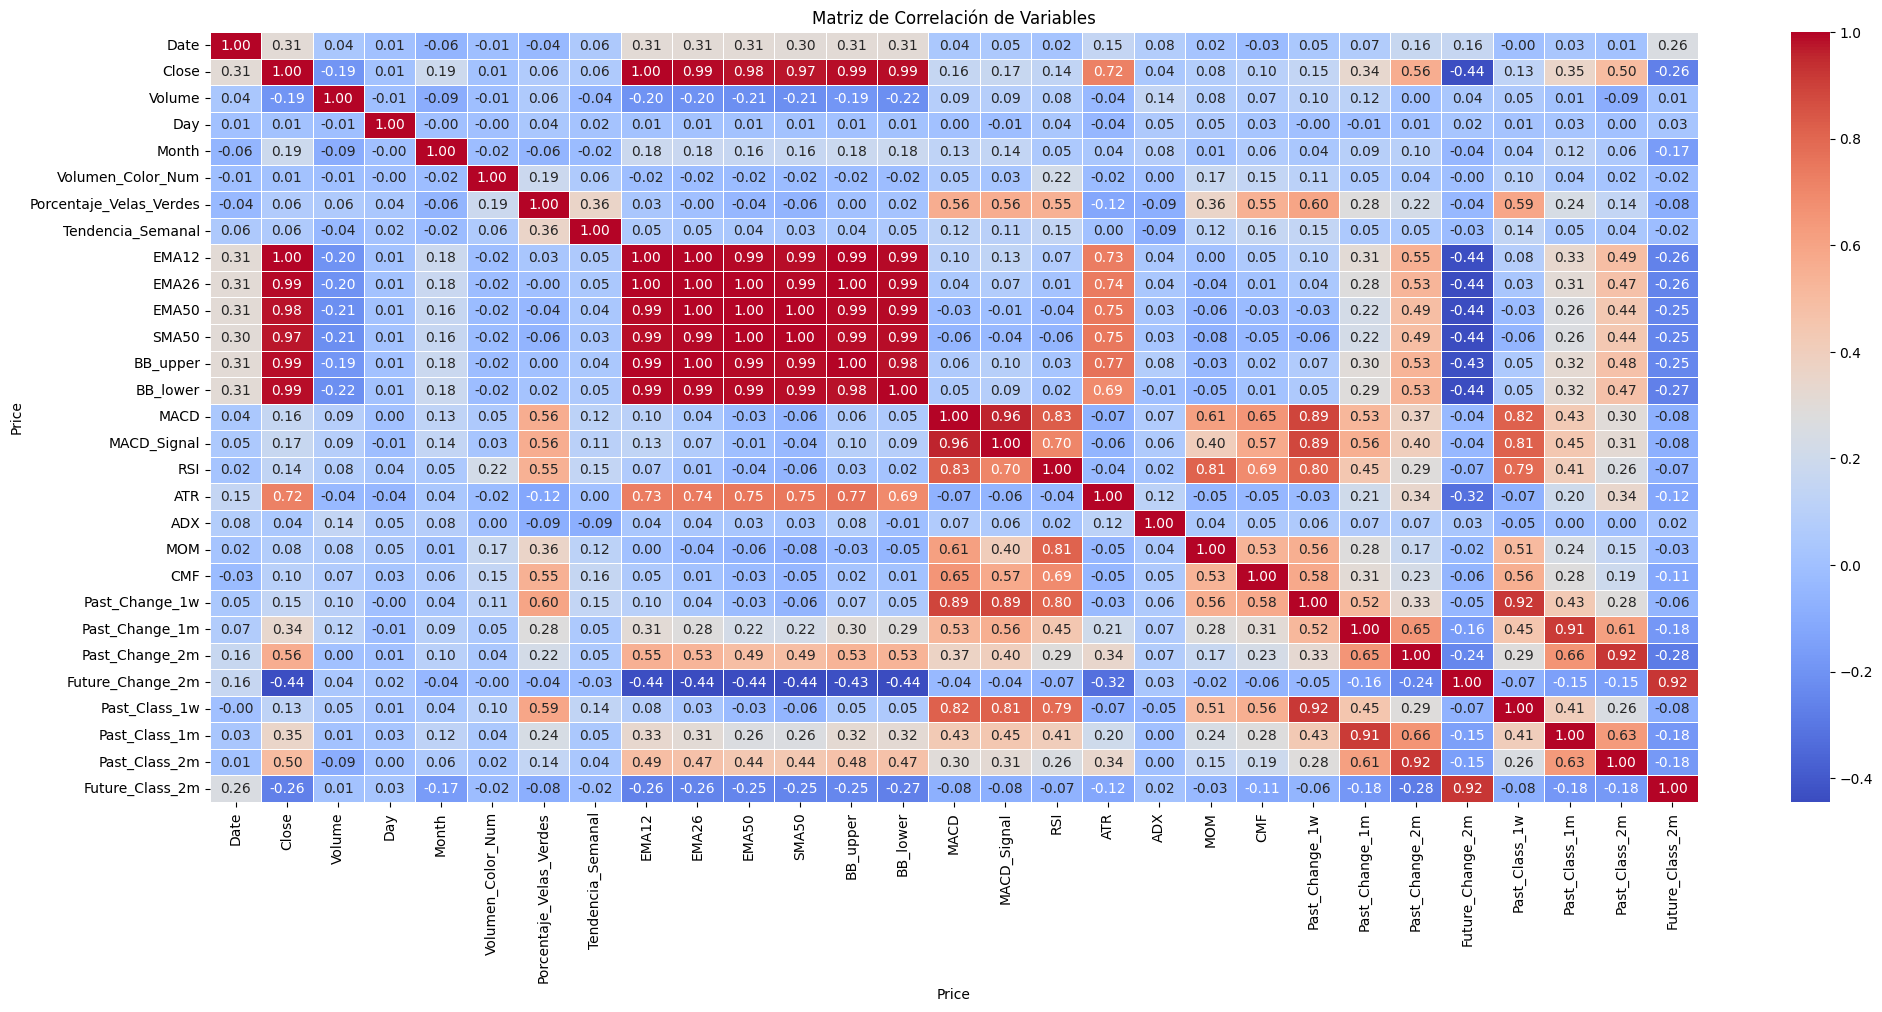

Price
Future_Class_2m            1.000000
Future_Change_2m           0.923384
Date                       0.259793
Day                        0.025469
ADX                        0.015742
Volume                     0.011958
Tendencia_Semanal         -0.015936
Volumen_Color_Num         -0.015944
MOM                       -0.034444
Past_Change_1w            -0.060439
RSI                       -0.069784
MACD                      -0.081379
MACD_Signal               -0.081933
Past_Class_1w             -0.083901
Porcentaje_Velas_Verdes   -0.084314
CMF                       -0.114744
ATR                       -0.121832
Month                     -0.166295
Past_Class_2m             -0.179229
Past_Change_1m            -0.182082
Past_Class_1m             -0.184322
BB_upper                  -0.246183
SMA50                     -0.248692
EMA50                     -0.249584
EMA26                     -0.256694
EMA12                     -0.260683
Close                     -0.264294
BB_lower              

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()
print(correlation_matrix['Future_Class_2m'].sort_values(ascending=False)) 

In [199]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report

# ===================== 📌 ELIMINAR VALORES NULOS =====================
data_train_2m = data.dropna()

print(data_train_2m["Future_Class_2m"].value_counts())

# ===================== 📌 PREPARAR LOS DATOS =====================
X = data_train_2m.drop(
    columns=["Future_Change_2m", "Future_Class_2m", "Date"]
)  # Características (todas menos la columna objetivo)
y = data_train_2m["Future_Class_2m"]  # Columna objetivo

# ===================== 📌 NORMALIZACIÓN =====================
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_2m = scaler.fit_transform(X)  # Aplicamos el escalado a las características

# ===================== 📌 DIVISIÓN ENTRE TRAIN Y TEST =====================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_2m, y, test_size=0.3, random_state=42
)

# ===================== 📌 INICIALIZAR MODELOS =====================
models_2m = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500,  # Más árboles para estabilidad
        max_depth=10,  # Evitar sobreajuste
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,  # Paralelización
    ),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_estimators=500,  # Más iteraciones
        learning_rate=0.01,  # Más bajo para estabilidad
        max_depth=6,  # Controla sobreajuste
        subsample=0.8,  # Evita overfitting
        colsample_bytree=0.8,
        gamma=0.1,  # Reduce falsos positivos
        min_child_weight=5,  # Evita divisiones poco útiles
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,  # Baja tasa para estabilidad
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,  # Evitar overfitting
        random_state=42,
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",  # Indicar que es clasificación multiclase
        num_class=5,  # Número total de clases
        n_estimators=500,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}

Future_Class_2m
1    1151
3     936
4     887
2     811
0     692
Name: count, dtype: int64


In [200]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
print(y_train.value_counts())
print(y_test.value_counts())

Future_Class_2m
1    801
3    646
4    630
2    577
0    479
Name: count, dtype: int64
Future_Class_2m
1    350
3    290
4    257
2    234
0    213
Name: count, dtype: int64


In [201]:
# ===================== 📌 ENTRENAR Y EVALUAR CADA MODELO =====================
predictions_2m = {}
for model_name, model in models_2m.items():
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir sobre el conjunto de prueba
    predictions_2m[model_name] = y_pred  # Guardar predicciones para 2 meses

# ===================== 📌 MOSTRAR MÉTRICAS PARA CADA MODELO =====================
model_metrics_2m = {}
for model_name, y_pred in predictions_2m.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    model_metrics_2m[model_name] = report  # Guardar métricas para 2 meses

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [202]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# ===================== 📌 EVALUAR MODELOS CON ACCURACY, F1-SCORE Y KAPPA =====================
model_scores_2m = {}

for model_name, y_pred in predictions_2m.items():
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 ponderado
    kappa = cohen_kappa_score(y_test, y_pred)  # Cohen's Kappa

    model_scores_2m[model_name] = {'accuracy': accuracy, 'f1_score': f1, 'kappa': kappa}

# ===================== 📌 ORDENAR MODELOS POR PRECISIÓN =====================
sorted_models_2m = sorted(model_scores_2m.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# ===================== 📌 IMPRIMIR LOS 3 MEJORES MODELOS =====================
print("🔹 Top 3 Modelos Basados en Precisión (2 meses):")
for i, (model_name, scores) in enumerate(sorted_models_2m[:3]):
    print(f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}")
    


🔹 Top 3 Modelos Basados en Precisión (2 meses):
1. LightGBM - Precisión: 0.9539 | F1-Score: 0.9538 | Kappa: 0.9419
2. Gradient Boosting - Precisión: 0.9531 | F1-Score: 0.9531 | Kappa: 0.9409
3. XGBoost - Precisión: 0.9234 | F1-Score: 0.9233 | Kappa: 0.9032


In [203]:
# ===================== 📌 MOSTRAR CANTIDAD DE CADA PREDICCIÓN POR MODELO (2 MESES) =====================
prediction_counts_2m = {}

for model_name, y_pred in predictions_2m.items():
    unique, counts = np.unique(y_pred, return_counts=True)  # Contar la frecuencia de cada predicción
    prediction_counts_2m[model_name] = dict(zip(unique, counts))  # Guardar conteo de predicciones

prediction_counts_2m

{'Random Forest': {0: 199, 1: 381, 2: 200, 3: 317, 4: 247},
 'XGBoost': {0: 203, 1: 366, 2: 217, 3: 306, 4: 252},
 'Gradient Boosting': {0: 210, 1: 357, 2: 229, 3: 295, 4: 253},
 'LightGBM': {0: 213, 1: 355, 2: 229, 3: 288, 4: 259}}

In [204]:
# ===================== 📌 CREAR DATAFRAME PARA ALMACENAR PREDICCIONES Y VALORES REALES (2 MESES) =====================
comparison_df_2m = {}

for model_name, y_pred in predictions_2m.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df_2m[model_name] = pd.DataFrame({
        'Real': y_test,  # Valores reales
        'Predicción': y_pred  # Predicciones del modelo
    })

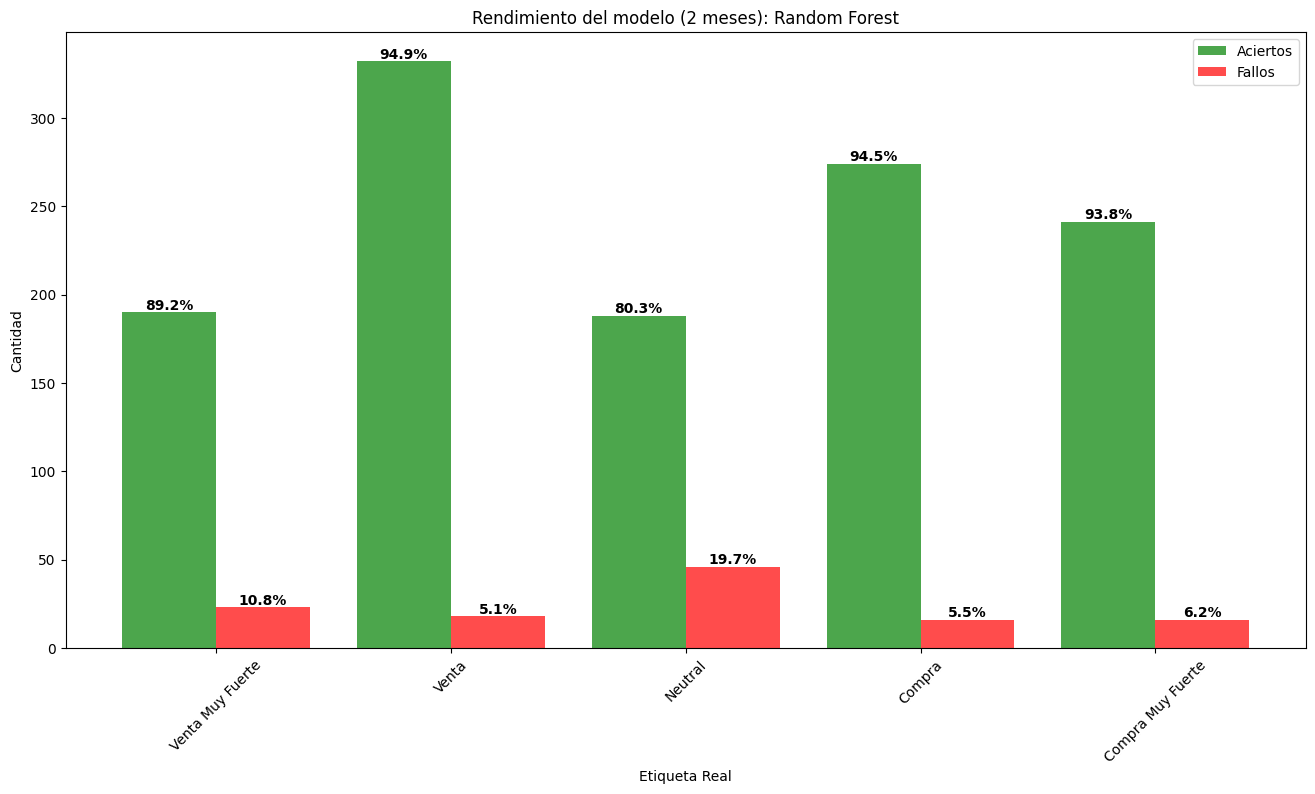

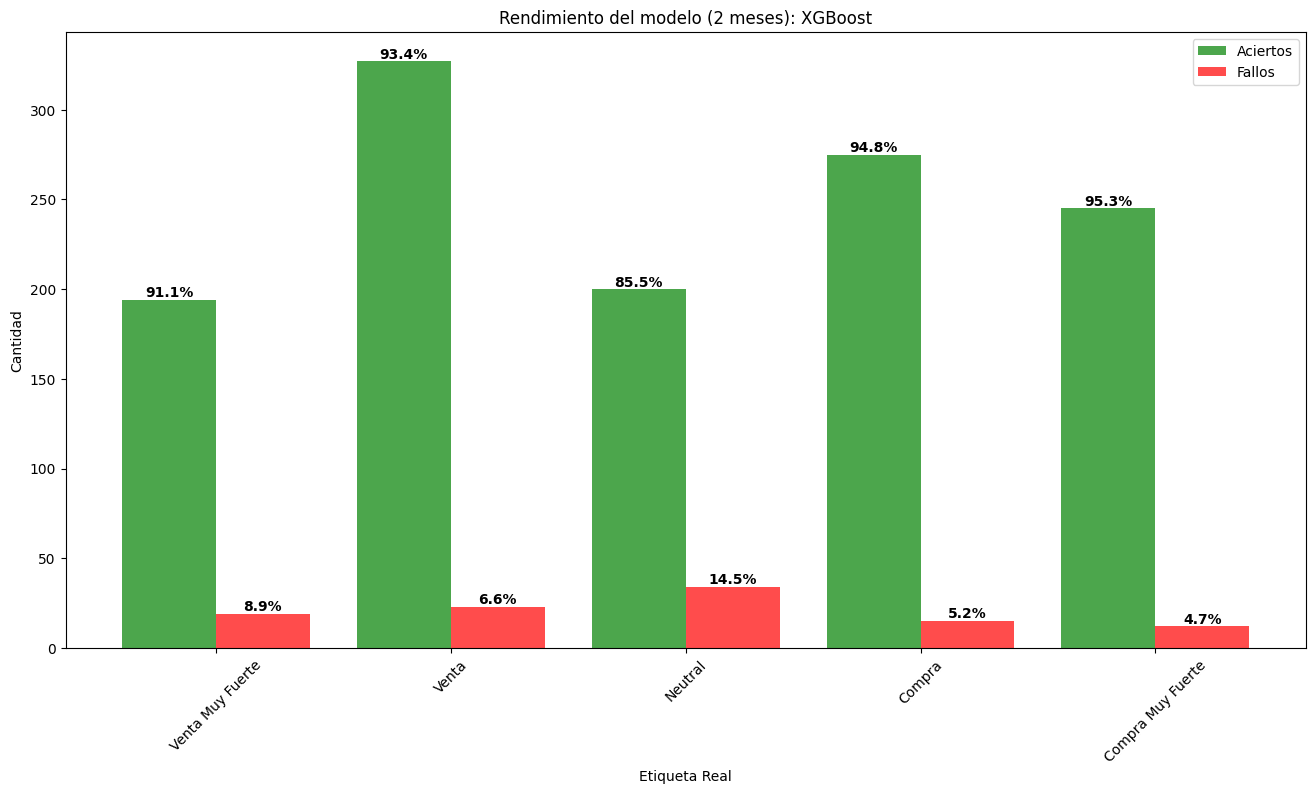

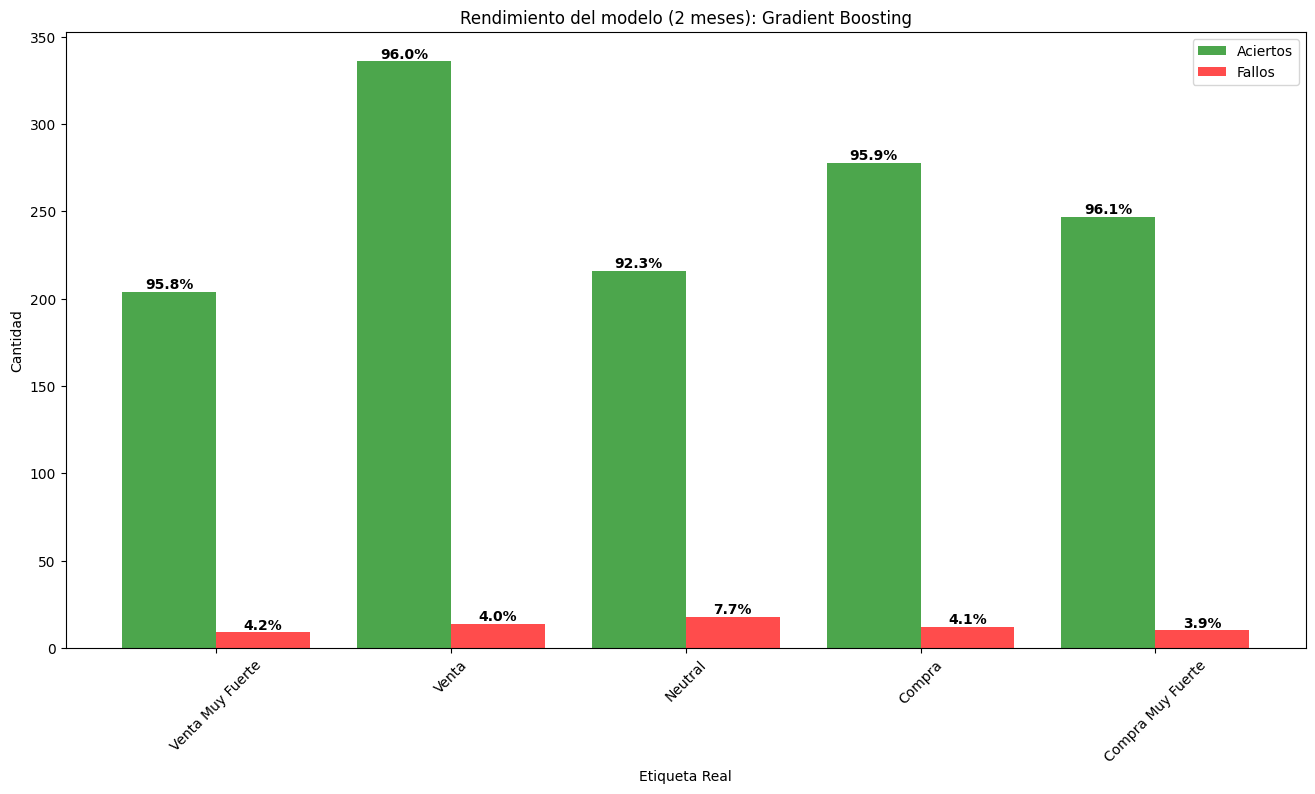

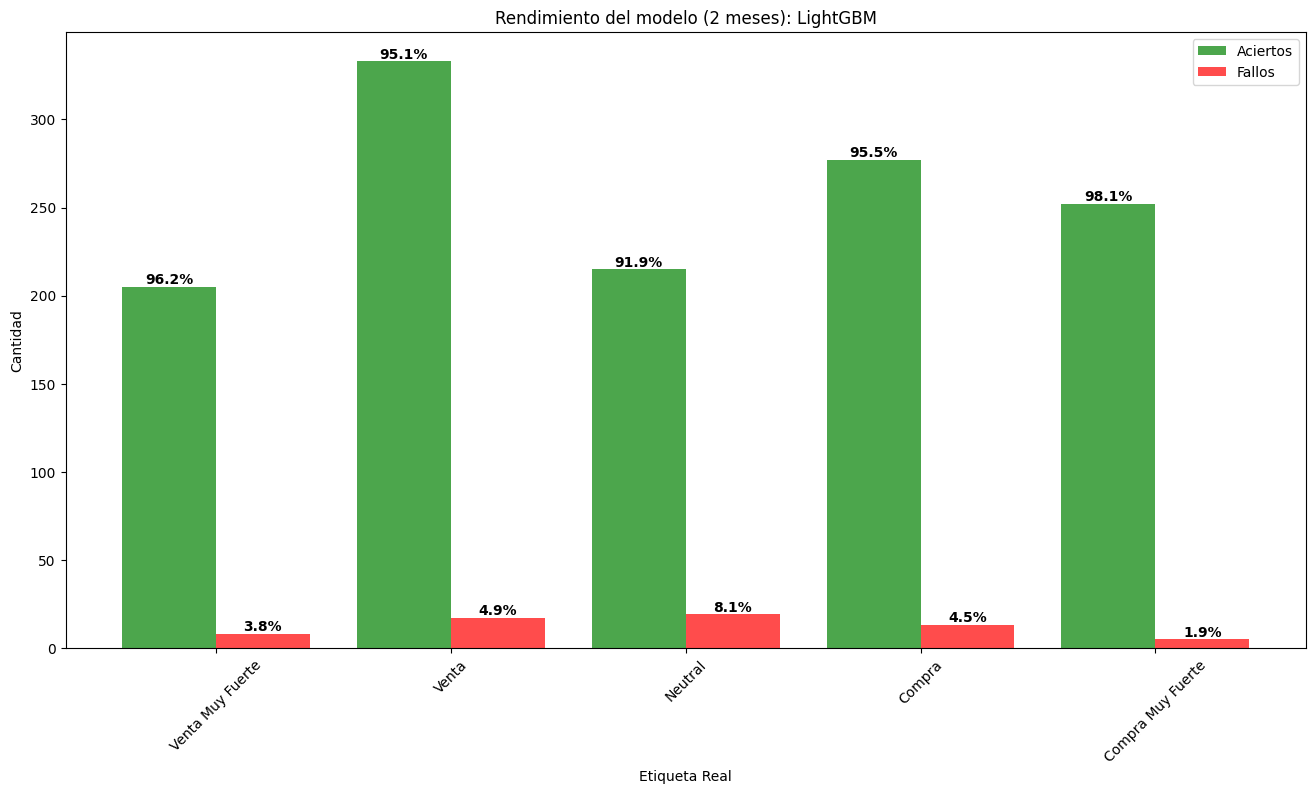

In [205]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: 'Venta Muy Fuerte',
    1: 'Venta',
    2: 'Neutral',
    3: 'Compra',
    4: 'Compra Muy Fuerte',
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones (2 meses)
comparison_df_2m = {}

for model_name, y_pred in predictions_2m.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({
        'Real': y_test, 
        'Predicción': y_pred
    })
    
    # Convertir los valores numéricos a etiquetas de texto
    df['Real'] = df['Real'].map(label_mapping)
    df['Predicción'] = df['Predicción'].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df['Real'] = pd.Categorical(df['Real'], categories=ordered_labels, ordered=True)
    df['Predicción'] = pd.Categorical(df['Predicción'], categories=ordered_labels, ordered=True)

    # Guardar en el diccionario
    comparison_df_2m[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta (2 meses)
for model_name, df in comparison_df_2m.items():
    df['Correcto'] = df['Real'] == df['Predicción']  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = df.groupby(['Real', 'Correcto'], observed=False).size().unstack(fill_value=0)

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: 'Aciertos', False: 'Fallos'})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=['Aciertos', 'Fallos'], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))
    
    # Barras de aciertos (izquierda)
    bars1 = plt.bar(x - width/2, results['Aciertos'], width=width, color='green', alpha=0.7, label='Aciertos')

    # Barras de fallos (derecha)
    bars2 = plt.bar(x + width/2, results['Fallos'], width=width, color='red', alpha=0.7, label='Fallos')

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages['Aciertos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct1:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    for bar, pct2 in zip(bars2, percentages['Fallos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct2:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 🔹 Formato final de la gráfica
    plt.title(f'Rendimiento del modelo (2 meses): {model_name}')
    plt.xlabel('Etiqueta Real')
    plt.ylabel('Cantidad')
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()


In [206]:
# Obtener los datos de ayer (última fila)
yesterday_data = data.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data['Date'].values[0]  
yesterday_close = yesterday_data['Close'].values[0]  

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=['Future_Change_2m', 'Future_Class_2m', 'Date'])
X_yesterday_2m_np = X_yesterday.to_numpy()  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models_2m.items():
    future_prediction = model.predict(X_yesterday_2m_np)[0]  # Obtener la predicción numérica
    
    future_predictions[model_name] = (
        f"📉 Caída muy fuerte (< {percentiles_future_2w[0]:.2f}%)" if future_prediction == 0 else
        f"🔻 Caída ({percentiles_future_2w[0]:.2f}% a {percentiles_future_2w[1]:.2f}%)" if future_prediction == 1 else
        f"🔻 Sin cambios significativos ({percentiles_future_2w[1]:.2f}% a {percentiles_future_2w[2]:.2f}%)" if future_prediction == 2 else
        f"➖ Subida ({percentiles_future_2w[2]:.2f}% a {percentiles_future_2w[3]:.2f}%)" if future_prediction == 3 else
        f"🚀 Subida muy fuerte (> {percentiles_future_2w[3]:.2f}%)"
    )

# Mostrar los resultados con fecha formateada correctamente
print(f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}")
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_2m' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


📅 Fecha de la última observación: 2025-03-18 19:30
💰 Precio de cierre: 225.48 USD

🔮 Predicciones de 'Future_Class_2m' para los datos de ayer:
⚡ Random Forest: 📉 Caída muy fuerte (< -13.00%)
⚡ XGBoost: 📉 Caída muy fuerte (< -13.00%)
⚡ Gradient Boosting: 📉 Caída muy fuerte (< -13.00%)
⚡ LightGBM: 📉 Caída muy fuerte (< -13.00%)


## Gráfica final para juntar ambas proyecciones de las predicciones

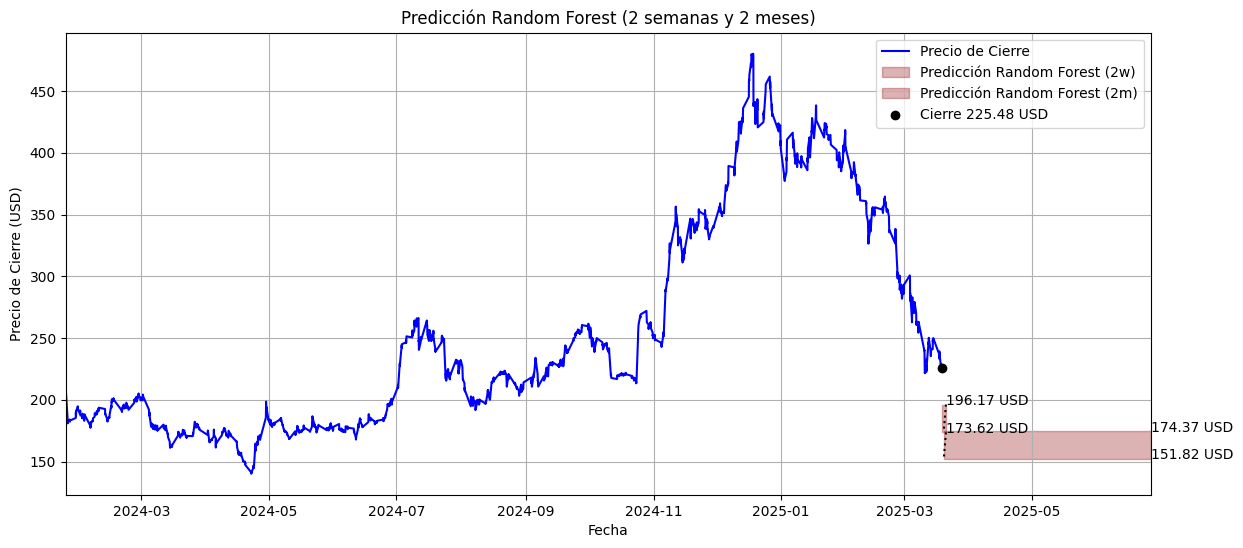

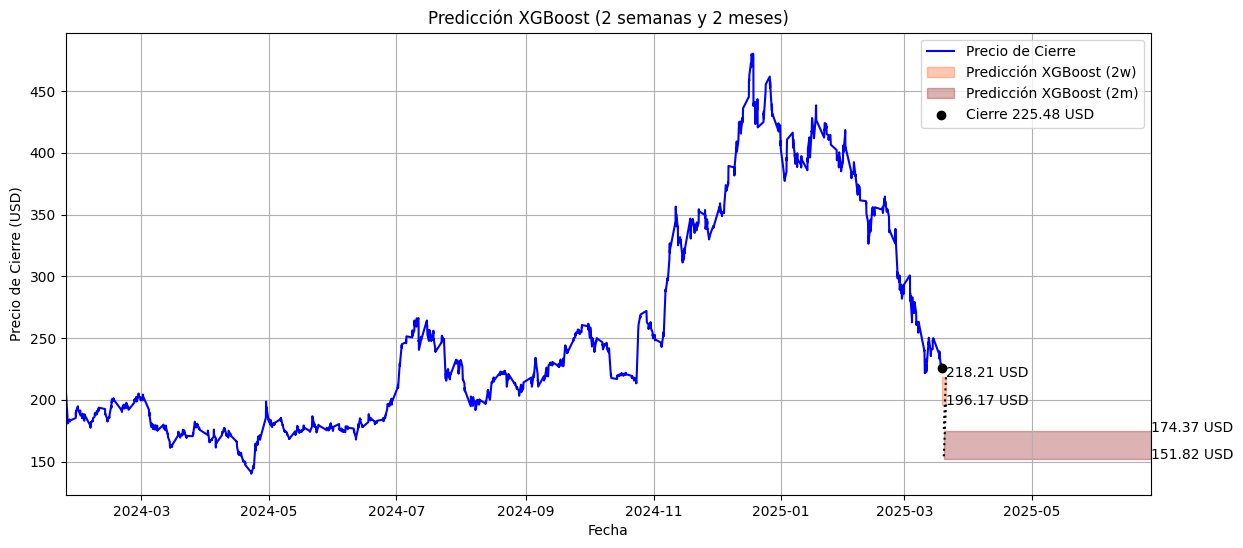

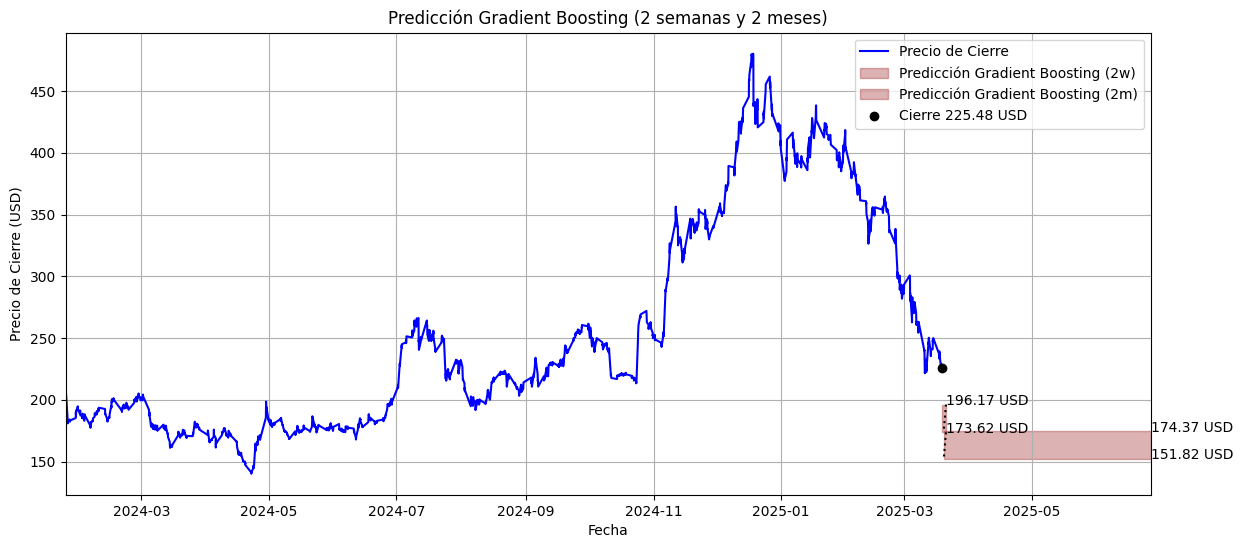

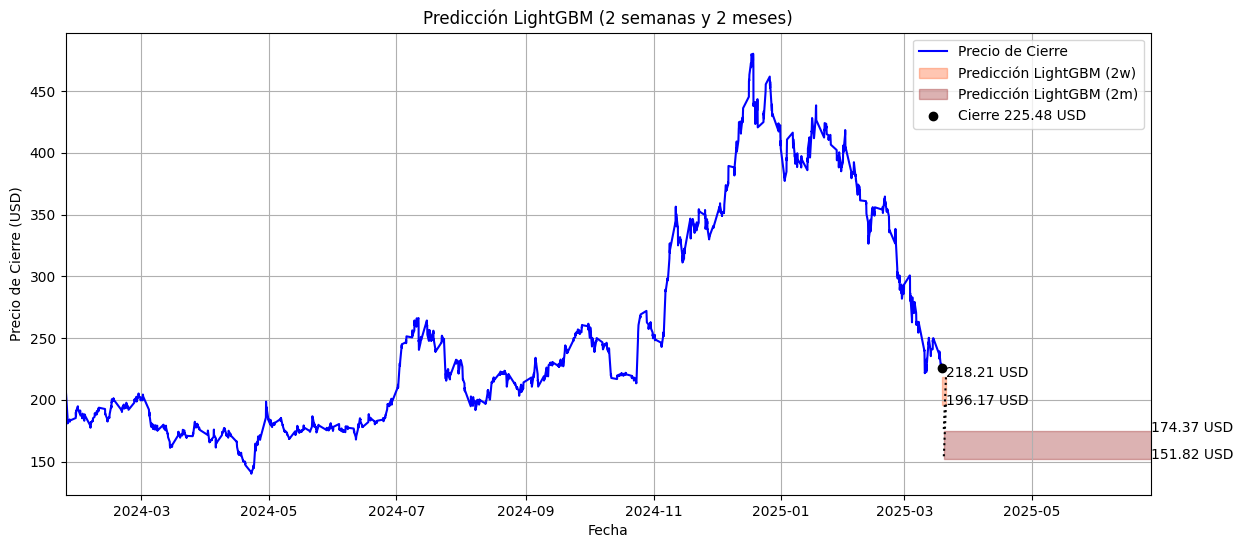

In [208]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Últimos 350 y 500 registros para graficar historial
data_last_350 = data.tail(650)
data_last_500 = data.tail(2000)

# Obtener datos de ayer (última fila)
yesterday_data = data.iloc[-1:]
yesterday_date = yesterday_data['Date'].values[0]
yesterday_close = yesterday_data['Close'].values[0]

# --- PREDICCIÓN A 2 SEMANAS ---
future_steps_2w = 50  
last_date_2w = data_last_350['Date'].max()
future_dates_2w = pd.date_range(start=last_date_2w, periods=future_steps_2w + 1, freq='h')[1:]

# --- PREDICCIÓN A 2 MESES ---
future_steps_2m = 100  
last_date_2m = data_last_500['Date'].max()
future_dates_2m = pd.date_range(start=last_date_2m, periods=future_steps_2m + 1, freq='D')[1:]

# --- GENERAR GRAFICOS COMBINADOS POR MODELO ---
for model_name in models.keys():
    model_2w = models[model_name]
    model_2m = models_2m[model_name]
    
    # Predicción 2 semanas
    future_prediction_2w = model_2w.predict(X_yesterday_2w_np)[0]
    if future_prediction_2w == 0:
        color_2w = 'darkred'
        label_text_2w = "Caída muy fuerte"
        pred_range_2w = (percentiles_future_2w[0] - 10, percentiles_future_2w[0])
    elif future_prediction_2w == 1:
        color_2w = 'orangered'
        label_text_2w = "Caída fuerte"
        pred_range_2w = (percentiles_future_2w[0], percentiles_future_2w[1])
    elif future_prediction_2w == 2:
        color_2w = 'gold'
        label_text_2w = "Caída moderada"
        pred_range_2w = (percentiles_future_2w[1], percentiles_future_2w[2])
    elif future_prediction_2w == 3:
        color_2w = 'yellow'
        label_text_2w = "Subida"
        pred_range_2w = (percentiles_future_2w[2], percentiles_future_2w[3])
    else:
        color_2w = 'darkgreen'
        label_text_2w = "Subida muy fuerte"
        pred_range_2w = (percentiles_future_2w[3], percentiles_future_2w[3]+10)

    lower_bound_2w = [yesterday_close * (1 + (pred_range_2w[0] / 100))] * len(future_dates_2w)
    upper_bound_2w = [yesterday_close * (1 + (pred_range_2w[1] / 100))] * len(future_dates_2w)

    # Predicción 2 meses
    future_prediction_2m = model_2m.predict(X_yesterday_2m_np)[0]
    if future_prediction_2m == 0:
        color_2m = 'darkred'
        label_text_2m = "Caída muy fuerte"
        pred_range_2m = (percentiles_future_2m[0] - 10, percentiles_future_2m[0])
    elif future_prediction_2m == 1:
        color_2m = 'orangered'
        label_text_2m = "Caída"
        pred_range_2m = (percentiles_future_2m[0], percentiles_future_2m[1])
    elif future_prediction_2m == 2:
        color_2m = 'gray'
        label_text_2m = "Sin cambios"
        pred_range_2m = (percentiles_future_2m[1], percentiles_future_2m[2])
    elif future_prediction_2m == 3:
        color_2m = 'yellow'
        label_text_2m = "Subida"
        pred_range_2m = (percentiles_future_2m[2], percentiles_future_2m[3])
    else:
        color_2m = 'darkgreen'
        label_text_2m = "Subida muy fuerte"
        pred_range_2m = (percentiles_future_2m[3], percentiles_future_2m[3] + 10)

    lower_bound_2m = [yesterday_close * (1 + (pred_range_2m[0] / 100))] * len(future_dates_2m)
    upper_bound_2m = [yesterday_close * (1 + (pred_range_2m[1] / 100))] * len(future_dates_2m)

    # --- GRAFICAR AMBAS PREDICCIONES ---
    plt.figure(figsize=(14, 6))
    
    # Histórico
    plt.plot(data_last_500['Date'], data_last_500['Close'], label='Precio de Cierre', color='blue')

    # Banda de predicción 2 semanas
    plt.fill_between(future_dates_2w, lower_bound_2w, upper_bound_2w, color=color_2w, alpha=0.3, label=f'Predicción {model_name} (2w)')
    
    # Etiquetas con precios en 2 semanas
    plt.text(future_dates_2w[-1], lower_bound_2w[-1], f'{lower_bound_2w[-1]:.2f} USD', color='black', fontsize=10)
    plt.text(future_dates_2w[-1], upper_bound_2w[-1], f'{upper_bound_2w[-1]:.2f} USD', color='black', fontsize=10)

    # Línea de conexión entre 2 semanas y 2 meses
    plt.plot([future_dates_2w[-1], future_dates_2m[0]], [lower_bound_2w[-1], lower_bound_2m[0]], color='black', linestyle='dotted')
    plt.plot([future_dates_2w[-1], future_dates_2m[0]], [upper_bound_2w[-1], upper_bound_2m[0]], color='black', linestyle='dotted')

    # Banda de predicción 2 meses
    plt.fill_between(future_dates_2m, lower_bound_2m, upper_bound_2m, color=color_2m, alpha=0.3, label=f'Predicción {model_name} (2m)')

    # Etiquetas con precios en 2 meses
    plt.text(future_dates_2m[-1], lower_bound_2m[-1], f'{lower_bound_2m[-1]:.2f} USD', color='black', fontsize=10)
    plt.text(future_dates_2m[-1], upper_bound_2m[-1], f'{upper_bound_2m[-1]:.2f} USD', color='black', fontsize=10)

    # Último cierre
    plt.scatter(yesterday_date, yesterday_close, color='black', zorder=3, label=f'Cierre {yesterday_close:.2f} USD')

    # Configuración del gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (USD)')
    plt.title(f'Predicción {model_name} (2 semanas y 2 meses)')
    plt.legend()
    plt.grid(True)
    plt.xlim(data_last_500['Date'].min(), future_dates_2m[-1])

    # Mostrar gráfico
    plt.show()


In [209]:
print("Distribución de clases en y_train:")
print(pd.Series(y_train).value_counts(normalize=True))

Distribución de clases en y_train:
Future_Class_2m
1    0.255665
3    0.206192
4    0.201085
2    0.184169
0    0.152889
Name: proportion, dtype: float64


In [210]:
# ✅ Escalar con el mismo MinMaxScaler entrenado en X_train
X_input = scaler.transform(X_yesterday_2m_np)

# 🔍 Verificar si los valores escalados están en el mismo rango de X_train
print("\n🔍 Comparación de X_input con X_train:")
print("Min en X_train:", X_train.min(axis=0))
print("Max en X_train:", X_train.max(axis=0))
print("Valores de X_input:\n", X_input)

# ✅ Asegurar que los valores no se salen del rango esperado
X_input = np.clip(X_input, X_train.min(axis=0), X_train.max(axis=0))

print("\n✅ X_input corregido después de aplicar clip:")
print(X_input)



🔍 Comparación de X_input con X_train:
Min en X_train: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00156011 0.         0.0056446  0.         0.
 0.         0.0036328  0.         0.         0.0016961  0.
 0.         0.        ]
Max en X_train: [1.         0.81864462 1.         1.         1.         0.94736842
 1.         1.         1.         1.         0.99973738 1.
 1.         1.         1.         0.98309289 1.         1.
 1.         1.         0.99334048 1.         1.         1.
 1.         1.        ]
Valores de X_input:
 [[0.31985583 0.07108218 0.56666667 0.18181818 0.         0.47368421
  0.5        0.33307261 0.35555836 0.38767148 0.36633995 0.36476035
  0.34183101 0.30329569 0.3110752  0.31536373 0.30357752 0.22585593
  0.2438331  0.30277933 0.34724474 0.06767644 0.02866079 0.5
  0.         0.        ]]

✅ X_input corregido después de aplicar clip:
[[0.31985583 0.07108218 0.56666667 0.181818

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [211]:
preds_test = models_2m['Random Forest'].predict(X_test[:100])
print("\n🔍 Predicciones en X_test (primeras 100 muestras):")
print(pd.Series(preds_test).value_counts())



🔍 Predicciones en X_test (primeras 100 muestras):
1    31
2    21
4    19
3    17
0    12
Name: count, dtype: int64


In [212]:
import numpy as np

def debug_prediction_process(data, x, models_2m, percentiles, periods_ahead, scaler=None):
    """Depura el proceso de predicción asegurando que el escalado sea correcto y que las predicciones sean variadas."""
    
    # Verificar si hay suficientes datos
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return
    
    # 🔹 Obtener datos del día específico
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data['Date']
    close_actual = specific_day_data['Close']
    
    # 🔹 Obtener datos del día futuro
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data['Date']
    close_future = future_day_data['Close']

    # 🔹 Cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características
    features = [col for col in data.columns if col not in ['Future_Change_2m', 'Future_Class_2m', 'Date']]
    X_yesterday_2m_np = specific_day_data[features].values.reshape(1, -1)  # Convertir a array 2D

    # 🚨 Aplicar escalado solo si el modelo fue entrenado con datos escalados
    if scaler:
        X_yesterday_2m_np_scaled = scaler.transform(X_yesterday_2m_np)
        X_input = X_yesterday_2m_np_scaled
        print("\n✅ Se aplica escalado a la entrada")
    else:
        X_input = X_yesterday_2m_np
        print("\n⚠️ No se está aplicando escalado a la entrada")


    specific_day_predictions = {}

    # 🔹 Iterar sobre cada modelo
    for model_name, model in models_2m.items():
        # 🔍 Obtener predicción
        raw_prediction = model.predict(X_input)

        # 🔹 Manejar modelos que devuelven probabilidades
        if raw_prediction.ndim > 1:
            future_prediction_2m = np.argmax(raw_prediction, axis=1)[0]
        else:
            future_prediction_2m = int(raw_prediction[0])
    
        specific_day_predictions[model_name] = future_prediction_2m

# 📌 Llamar a la función de depuración
debug_prediction_process(data, x=1750, models_2m=models_2m, percentiles=percentiles_future_2m, periods_ahead=280, scaler=scaler)



✅ Se aplica escalado a la entrada


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Modelo Random Forest - Predicción: 0
Modelo XGBoost - Predicción: 0
Modelo Gradient Boosting - Predicción: 0
Modelo LightGBM - Predicción: 0

📅 Fecha evaluada: 2025-01-17 20:30:00
💰 Cierre en la fecha evaluada: 426.48 USD
📅 Fecha futura (2 meses después): 2025-03-18 19:30:00
💰 Cierre en la fecha futura: 225.48 USD
📈 Cambio real en porcentaje: -47.13%

🔍 Predicciones de los modelos y precios proyectados:
   Random Forest: Predicción = 0 | Rango esperado = 204.35 - 329.81 USD
   🎯 Rango de percentiles: -52.08% - -22.67% -> ✅ Acertó!
   XGBoost: Predicción = 0 | Rango esperado = 204.35 - 329.81 USD
   🎯 Rango de percentiles: -52.08% - -22.67% -> ✅ Acertó!
   Gradient Boosting: Predicción = 0 | Rango esperado = 204.35 - 329.81 USD
   🎯 Rango de percentiles: -52.08% - -22.67% -> ✅ Acertó!
   LightGBM: Predicción = 0 | Rango esperado = 204.35 - 329.81 USD
   🎯 Rango de percentiles: -52.08% - -22.67% -> ✅ Acertó!


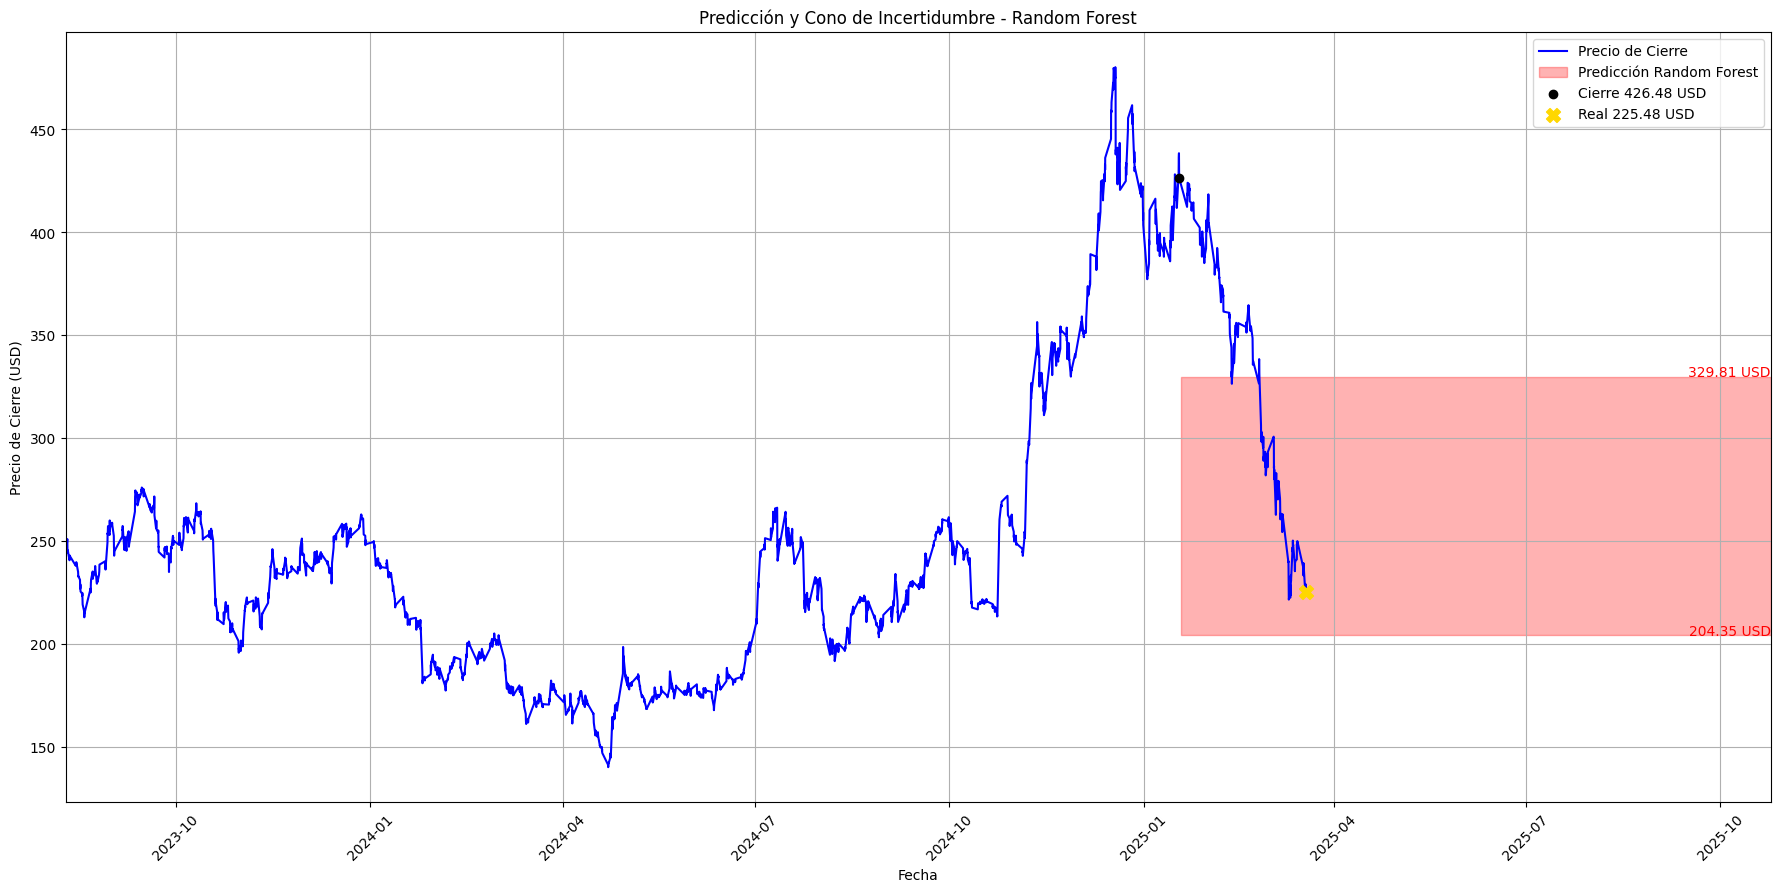

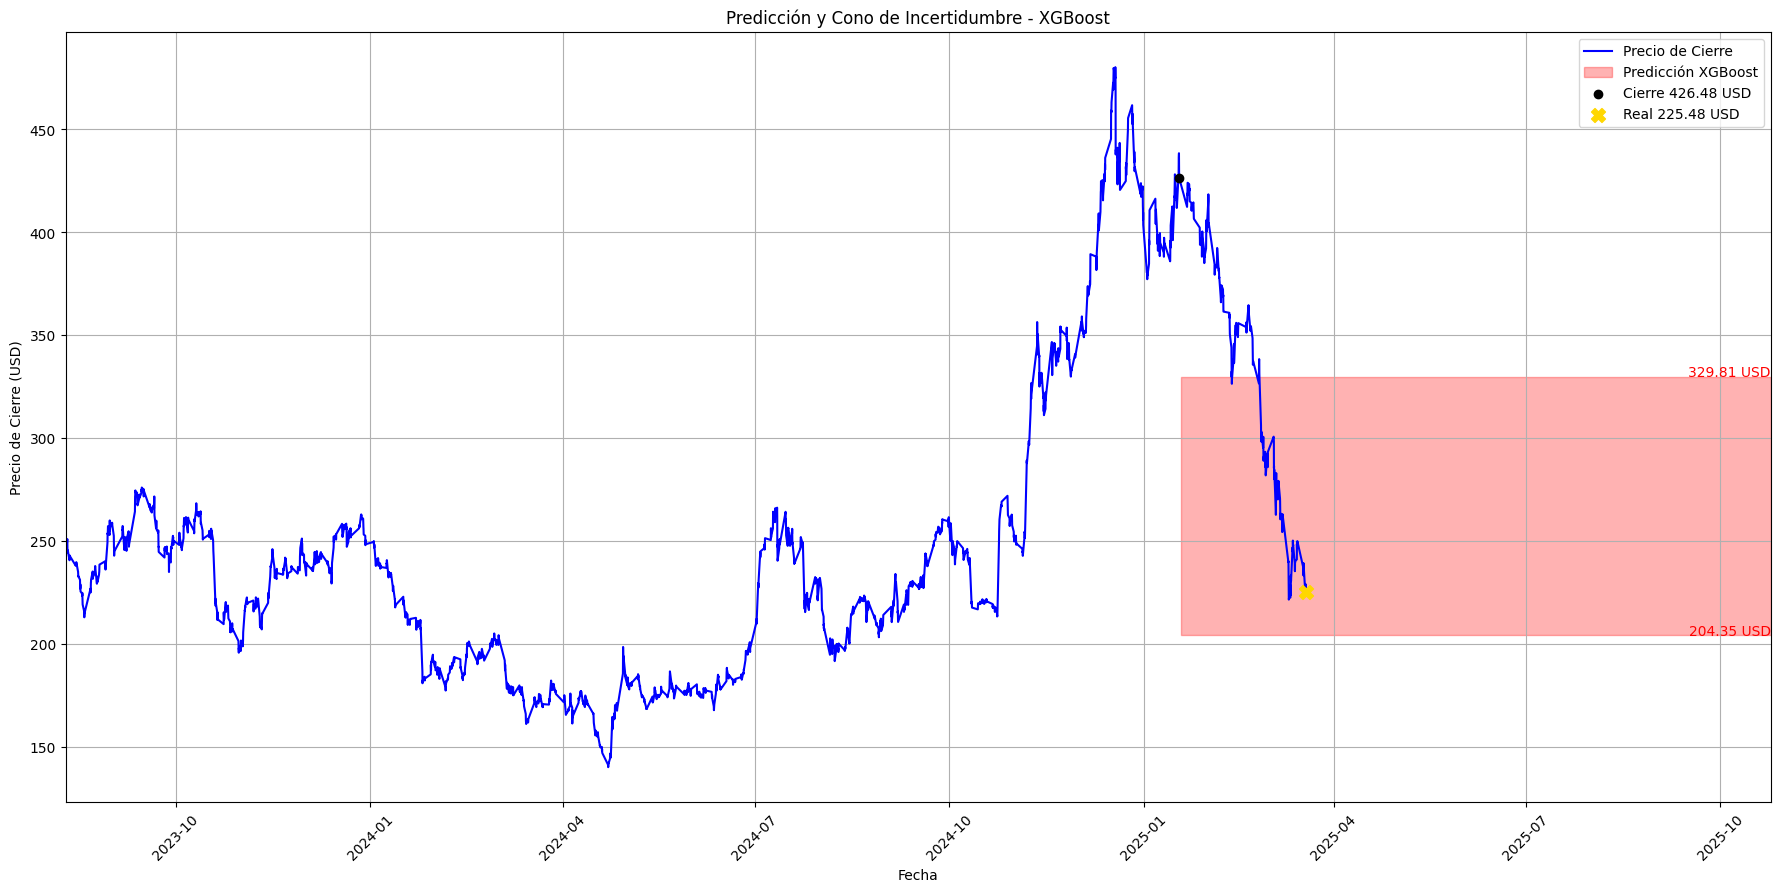

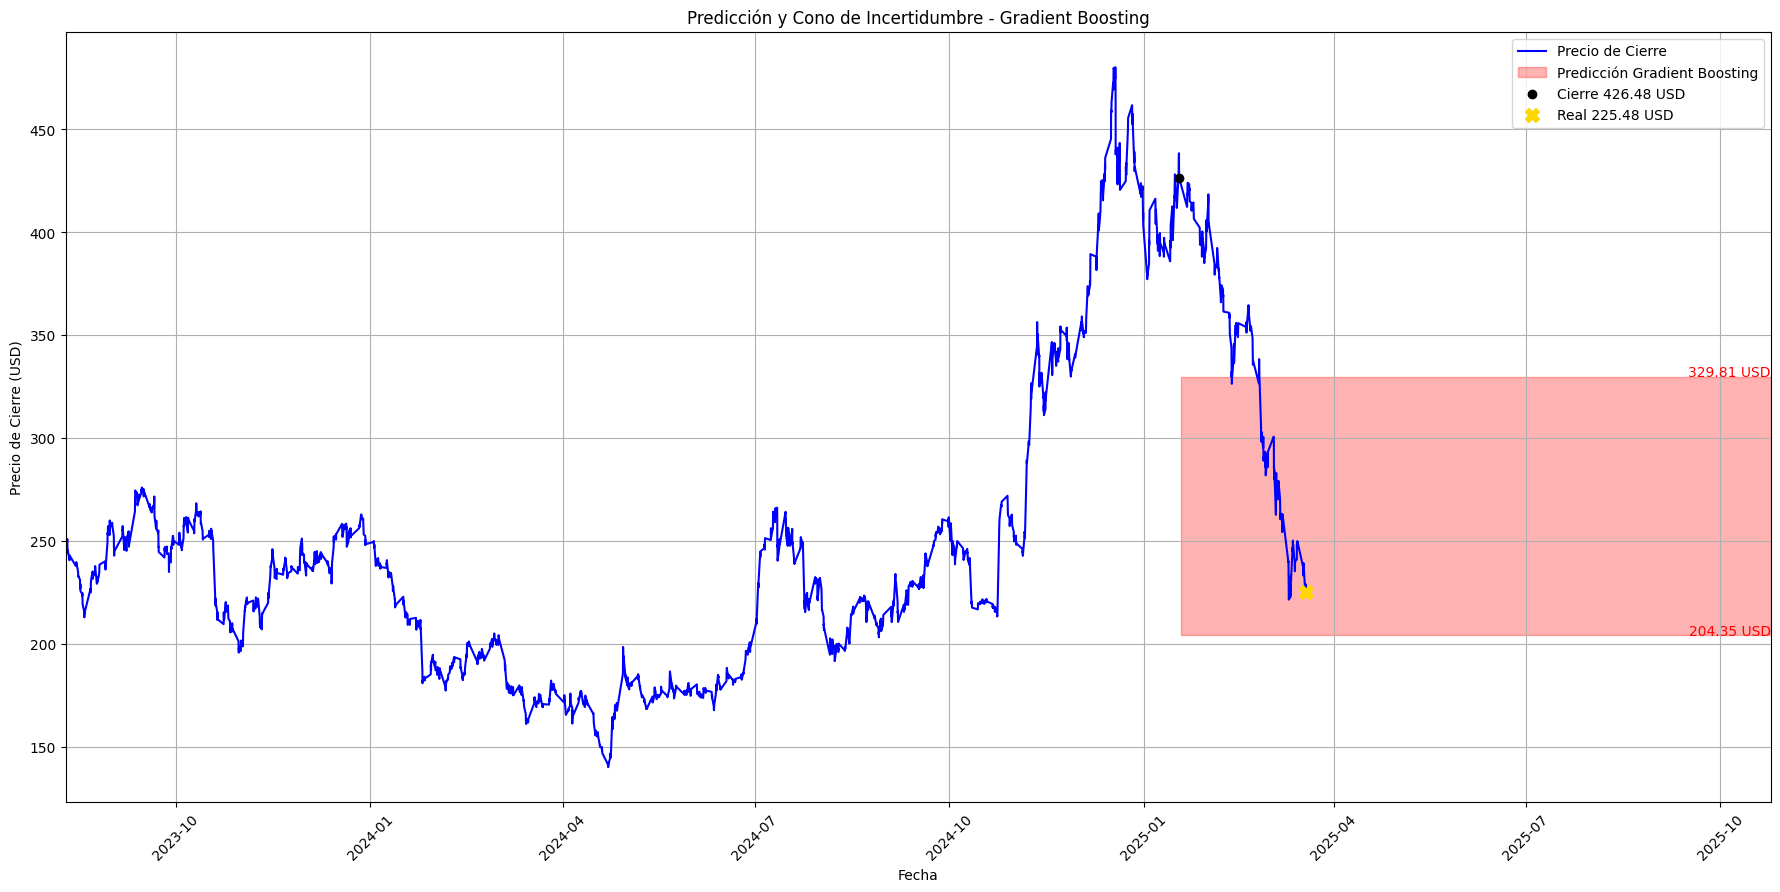

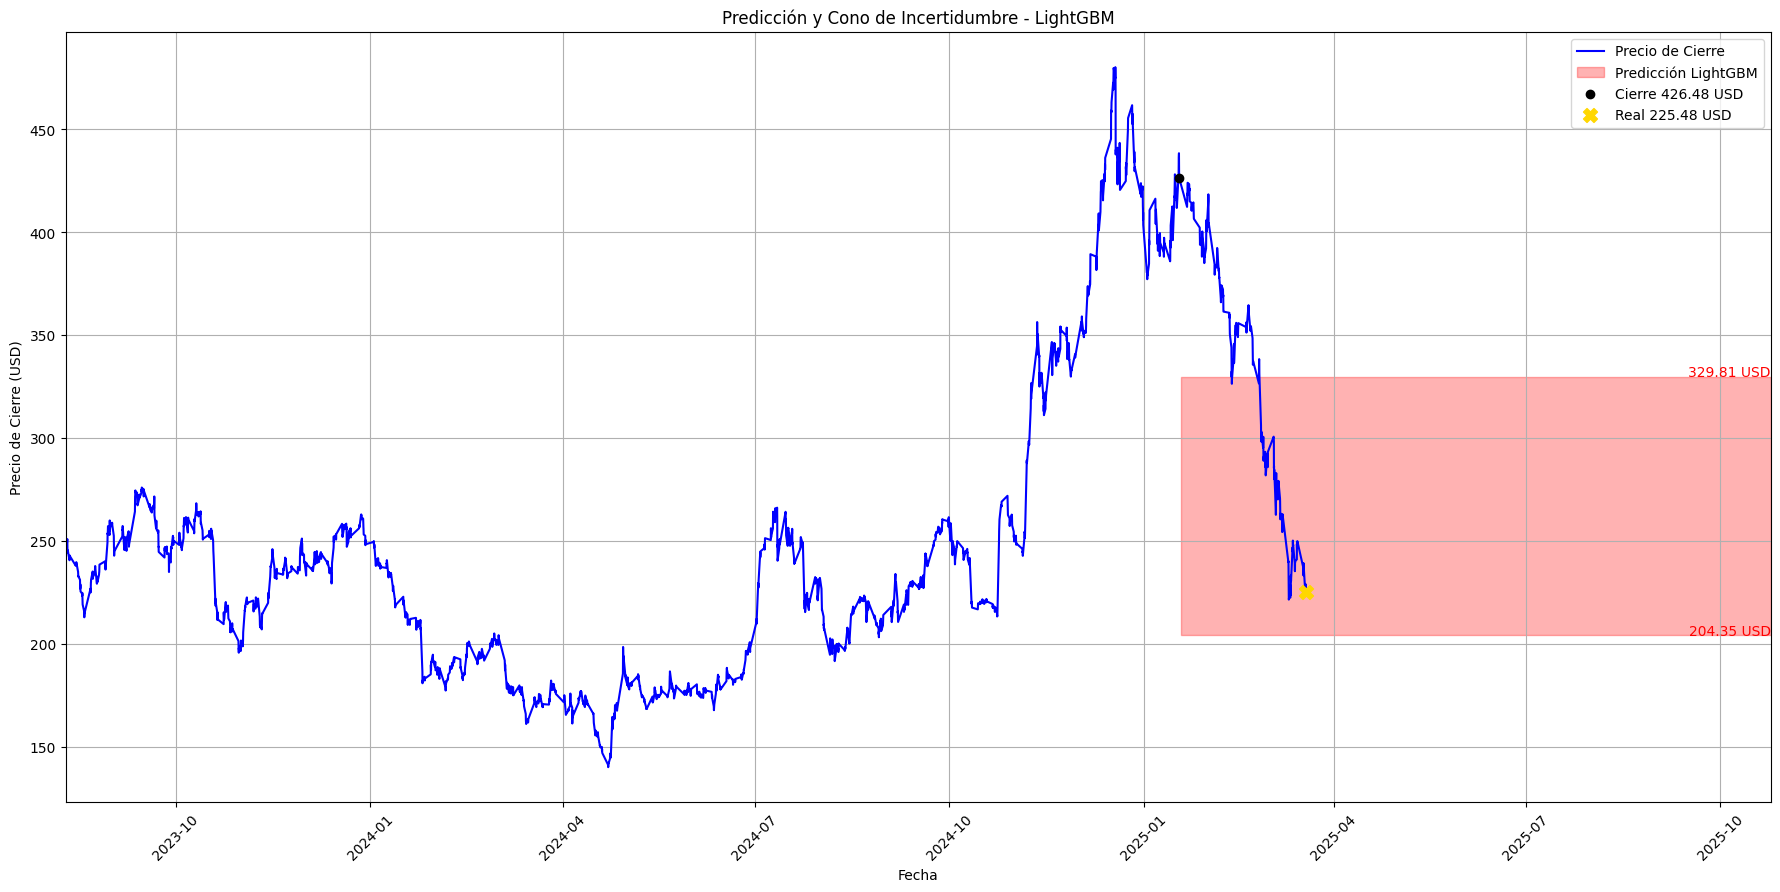

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def check_prediction_with_cone(data, x, models_2m, percentiles, periods_ahead, num_days_to_plot=200, scaler=None, X_test=None):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return
    
    # 🔹 Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data['Date']
    close_actual = specific_day_data['Close']
    
    # 🔹 Obtener datos del punto futuro donde se verificará la predicción
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data['Date']
    close_future = future_day_data['Close']

    # 🔹 Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características para la predicción
    features = [col for col in data.columns if col not in ['Future_Change_2m', 'Future_Class_2m', 'Date']]
    X_yesterday_2m_np = specific_day_data[features].values.reshape(1, -1)

    # ✅ Aplicar el mismo escalado de entrenamiento
    if scaler:
        X_yesterday_2m_np_scaled = scaler.transform(X_yesterday_2m_np)

        # 🔍 Validar que los valores no salgan de rango
        X_yesterday_2m_np_scaled = np.clip(X_yesterday_2m_np_scaled, X_test.min(axis=0), X_test.max(axis=0))
    else:
        X_yesterday_2m_np_scaled = X_yesterday_2m_np  # No aplicar escalado si no se usó en entrenamiento

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models_2m.items():
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_yesterday_2m_np_scaled)
            future_prediction_2m = np.argmax(probs, axis=1)[0]
        else:
            future_prediction_2m = int(model.predict(X_yesterday_2m_np_scaled)[0])

        print(f"Modelo {model_name} - Predicción: {future_prediction_2m}")
        specific_day_predictions[model_name] = future_prediction_2m

        # 🔹 Determinar el rango según la predicción con 5 casos (0 a 4)
        # 🔹 Obtener el mínimo y máximo real de `Future_Change_2m`
        min_change = data['Future_Change_2m'].min()
        max_change = data['Future_Change_2m'].max()

        # 🔹 Determinar el rango según la predicción con 5 casos (0 a 4)
        prediction_ranges = [
            (min_change, percentiles[0]),   # 0: Caída muy fuerte (mínimo real hasta percentil 15)
            (percentiles[0], percentiles[1]),  # 1: Caída
            (percentiles[1], percentiles[2]),  # 2: Neutral
            (percentiles[2], percentiles[3]),  # 3: Subida
            (percentiles[3], max_change),   # 4: Subida fuerte (percentil 80 hasta el máximo real)
        ]

        
        colors = ['red', 'orangered', 'gray', 'limegreen', 'darkgreen']
        
        pred_range = prediction_ranges[future_prediction_2m]
        color = colors[future_prediction_2m]

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (projected_price_min, projected_price_max, pred_range[0], pred_range[1])

    # 📌 Mostrar resultados
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(f"📅 Fecha futura (2 meses después): {future_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"📈 Cambio real en porcentaje: {real_change_percent:.2f}%\n")

    print("🔍 Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[model_name]
        
        resultado = "✅ Acertó!" if percentile_min <= real_change_percent <= percentile_max else "❌ No acertó."

        print(f"   {model_name}: Predicción = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD")
        print(f"   🎯 Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}")

    # 🚀 Graficar con el cono de predicción
    future_steps = periods_ahead
    future_dates = pd.date_range(start=specific_date, periods=future_steps + 1, freq='D')[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        plt.figure(figsize=(22, 10))
        plt.plot(data.iloc[-num_days_to_plot:]['Date'], 
                 data.iloc[-num_days_to_plot:]['Close'], 
                 label='Precio de Cierre', color='blue')

        # 🔹 Graficar el cono de predicción
        lower_bound = [close_actual * (1 + (projected_prices[model_name][2] / 100))] * len(future_dates)
        upper_bound = [close_actual * (1 + (projected_prices[model_name][3] / 100))] * len(future_dates)

        plt.fill_between(future_dates, lower_bound, upper_bound, color=colors[prediction], alpha=0.3, label=f'Predicción {model_name}')
        
        plt.text(future_dates[-1], lower_bound[-1], f"{lower_bound[-1]:.2f} USD", color=colors[prediction], fontsize=10, ha='right')
        plt.text(future_dates[-1], upper_bound[-1], f"{upper_bound[-1]:.2f} USD", color=colors[prediction], fontsize=10, ha='right')

        plt.scatter(specific_date, close_actual, color='black', zorder=3, label=f'Cierre {close_actual:.2f} USD')
        plt.scatter(future_date, close_future, color='gold', marker='X', s=100, zorder=4, label=f'Real {close_future:.2f} USD')

        plt.xlabel('Fecha')
        plt.ylabel('Precio de Cierre (USD)')
        plt.title(f'Predicción y Cono de Incertidumbre - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

        plt.xlim(data.iloc[-num_days_to_plot]['Date'], future_dates[-1])
        plt.show()

# 📌 Llamada a la función con los parámetros corregidos
check_prediction_with_cone(data, x=281, models_2m=models_2m, percentiles=percentiles_future_2m, periods_ahead=280, num_days_to_plot=2800, scaler=scaler, X_test=X_test)



🔢 Conteo de predicciones para el modelo Random Forest:
Clase 0: 199 veces
Clase 1: 381 veces
Clase 2: 200 veces
Clase 3: 317 veces
Clase 4: 247 veces

🔢 Conteo de predicciones para el modelo XGBoost:
Clase 0: 203 veces
Clase 1: 366 veces
Clase 2: 217 veces
Clase 3: 306 veces
Clase 4: 252 veces

🔢 Conteo de predicciones para el modelo Gradient Boosting:
Clase 0: 210 veces
Clase 1: 357 veces
Clase 2: 229 veces
Clase 3: 295 veces
Clase 4: 253 veces

🔢 Conteo de predicciones para el modelo LightGBM:
Clase 0: 213 veces
Clase 1: 355 veces
Clase 2: 229 veces
Clase 3: 288 veces
Clase 4: 259 veces


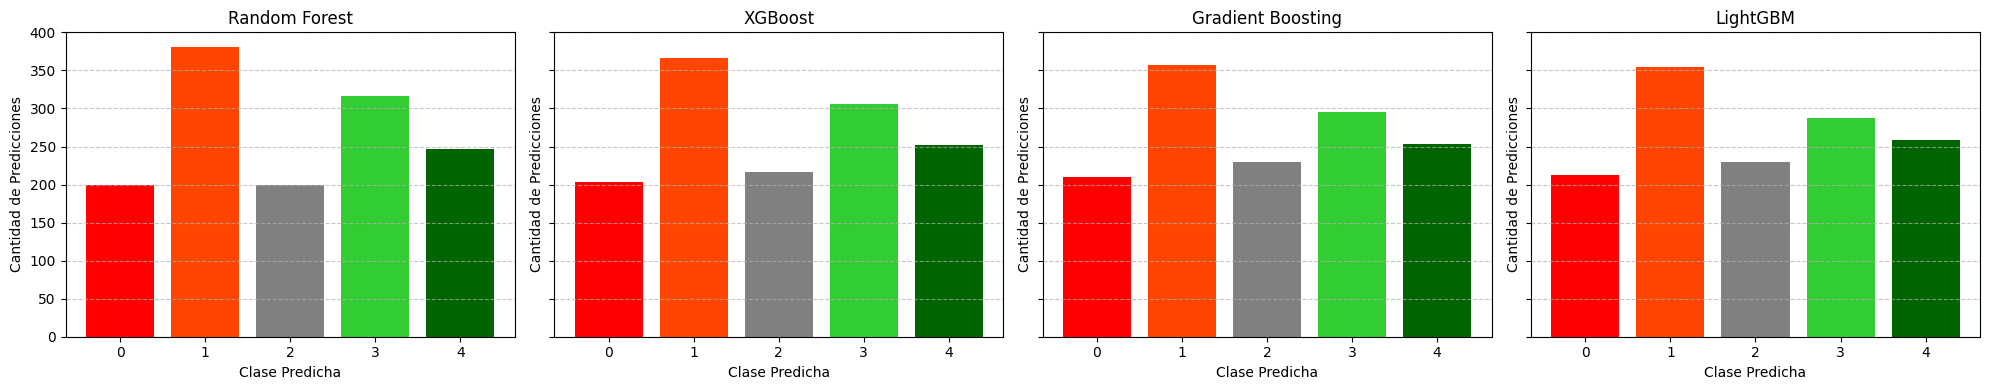

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def count_predictions_2m(X_test, models_2m, y_test):
    """Genera gráficos de distribución de predicciones por clase para cada modelo en models_2m."""
    
    # Obtener el número total de modelos
    num_models = len(models_2m)

    # Configurar subgráficos (1 fila, n columnas según número de modelos)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 4), sharey=True)

    if num_models == 1:  # Si solo hay un modelo, asegurarse de que axes sea una lista
        axes = [axes]

    # Definir colores para cada clase (0-4)
    colors = ['red', 'orangered', 'gray', 'limegreen', 'darkgreen']
    all_classes = [0, 1, 2, 3, 4]  # Asegurar que todas las clases se muestran

    # Iterar sobre cada modelo y graficar sus predicciones
    for ax, (model_name, model) in zip(axes, models_2m.items()):
        predictions = model.predict(X_test)  # Obtener predicciones en el conjunto de prueba
        class_counts = Counter(predictions)  # Contar ocurrencias de cada clase

        # Asegurar que todas las clases aparecen en el diccionario (aunque tengan valor 0)
        class_counts = {cls: class_counts.get(cls, 0) for cls in all_classes}

        # Imprimir conteo de predicciones
        print(f"\n🔢 Conteo de predicciones para el modelo {model_name}:")
        for class_label, count in sorted(class_counts.items()):
            print(f"Clase {class_label}: {count} veces")

        # Crear gráfico de barras
        ax.bar(class_counts.keys(), class_counts.values(), color=colors)
        ax.set_xlabel("Clase Predicha")
        ax.set_ylabel("Cantidad de Predicciones")
        ax.set_title(f"{model_name}")
        ax.set_xticks(all_classes)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustar diseño y mostrar gráfico
    plt.tight_layout()
    plt.show()

# 📌 Llamar a la función con X_test en lugar de data
count_predictions_2m(X_test, models_2m, y_test)
